# Import

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import warnings
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
import optuna
import pickle
import joblib
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import root_mean_squared_log_error, mean_squared_log_error, mean_squared_error, r2_score
from custom_metrics import (
    lgb_lse_objective, lgb_lse_objective_with_inverse, lgb_rmsle, lgb_rmsle_with_inverse, 
    xgb_rmsle_evaluation, xgb_rmsle_evaluation_with_inverse, xgb_sle_objective, xgb_sle_objective_with_inverse,
    RmsleMetric, SleObjective # for catboost rmsle
)


import logging
logging.basicConfig(level=logging.ERROR)
plt.rcParams['figure.figsize'] = [21, 9]
plt.rcParams['figure.dpi'] = 300

# 다크모드에 맞는 스타일 설정
plt.style.use('dark_background')

# 추가적인 커스터마이징 (옵션)
plt.rcParams.update({
    'axes.edgecolor': 'white',         # 축의 테두리 색상
    'axes.labelcolor': 'white',       # 축 라벨 색상
    'xtick.color': 'white',           # x축 눈금 색상
    'ytick.color': 'white',           # y축 눈금 색상
    'grid.color': 'gray',             # 그리드 라인 색상
    'grid.alpha': 0.3,                # 그리드 투명도
    'text.color': 'white',            # 텍스트 색상
    'figure.facecolor': '#121212',    # 전체 그림 배경색
    'axes.facecolor': '#121212',      # 축 배경색
    'legend.facecolor': '#1e1e1e',    # 범례 배경색
    'legend.edgecolor': 'white',      # 범례 테두리 색상
})
plt.rcParams['agg.path.chunksize'] = 10000
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
REDRAW = False

c:\Users\gus47\Desktop\workspace\kaggle\regression-with-an-insurance-dataset\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Original dataset: https://www.kaggle.com/datasets/schran/insurance-premium-prediction/data

# Load Data

In [4]:
# 캐글 노트북이면 True, 아니면 False
if 'KAGGLE_URL_BASE' in os.environ:
    train_data = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv', index_col=0)
    test_data = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv', index_col=0)
else:
    train_data = pd.read_csv('./kaggle/input/playground-series-s4e12/train.csv', index_col=0)
    test_data = pd.read_csv('./kaggle/input/playground-series-s4e12/test.csv', index_col=0)
    
# non_log_oof, non_log_test = joblib.load(
#     './kaggle/input/cat_non_loged_origin.pkl'
# )
# non_log_oof, non_log_test = joblib.load(
#     './kaggle/input/cat_non_loged_simpler_date.pkl'
# )
non_log_oof, non_log_test = joblib.load(
    './kaggle/input/cat_non_loged.pkl'
)

In [5]:
train_data.columns = train_data.columns.str.lower().str.replace(' ', '_')
test_data.columns = test_data.columns.str.lower().str.replace(' ', '_')

train_data['non_log'] = non_log_oof
test_data['non_log'] = non_log_test
# 타겟 변수 및 피처 분리
target_column = 'premium_amount'
data = pd.concat([train_data, test_data]).drop(columns=target_column)
y = train_data[target_column].values
del train_data, test_data

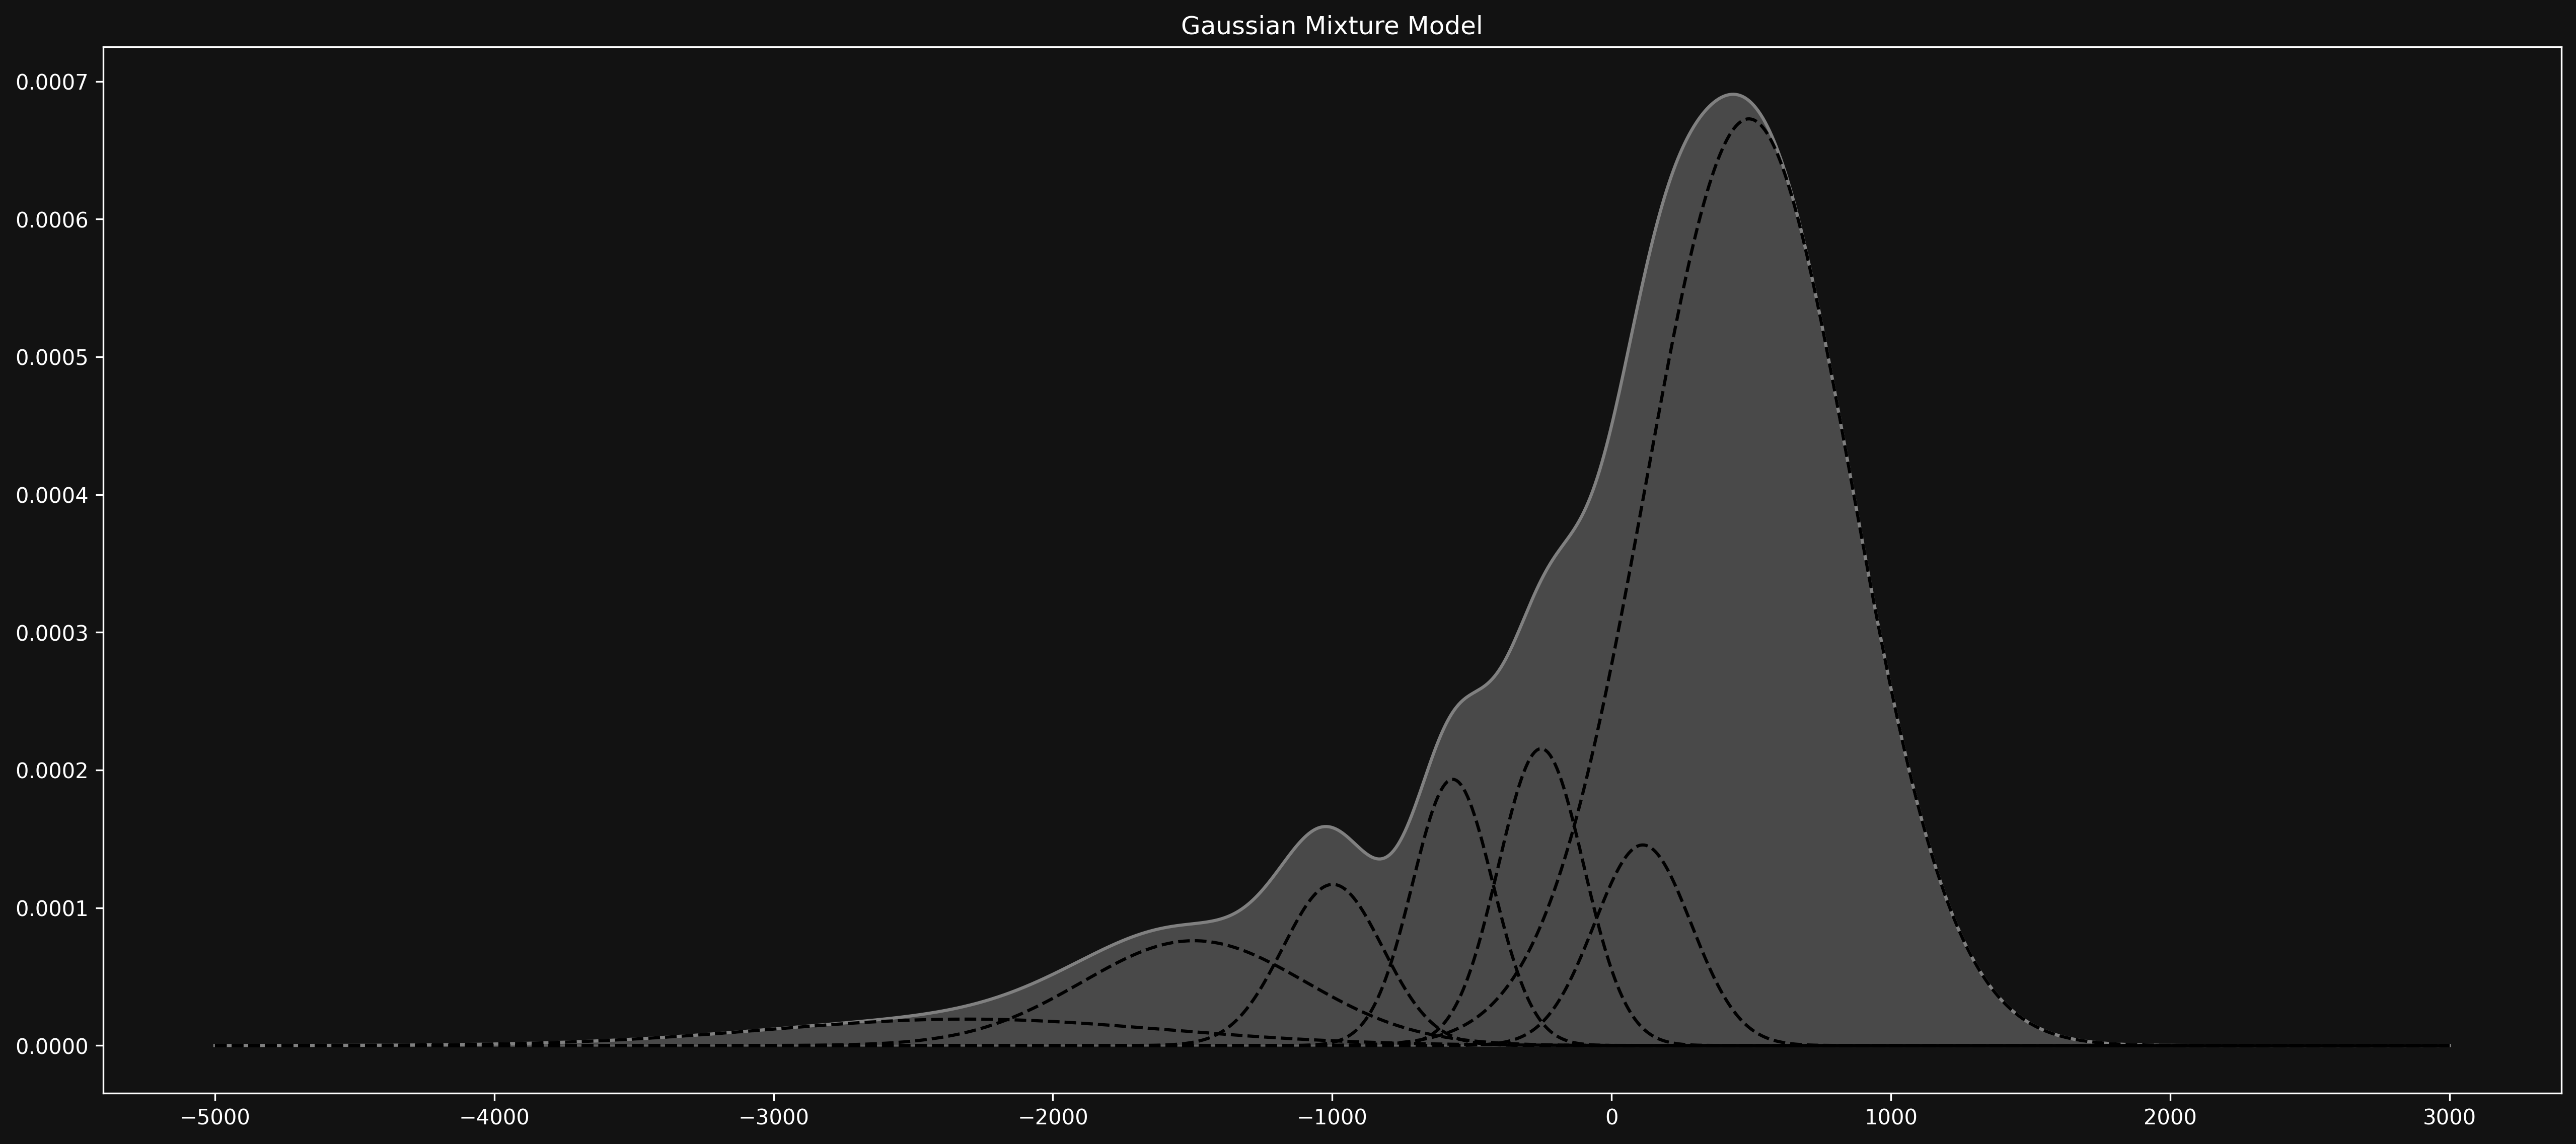

<Axes: >

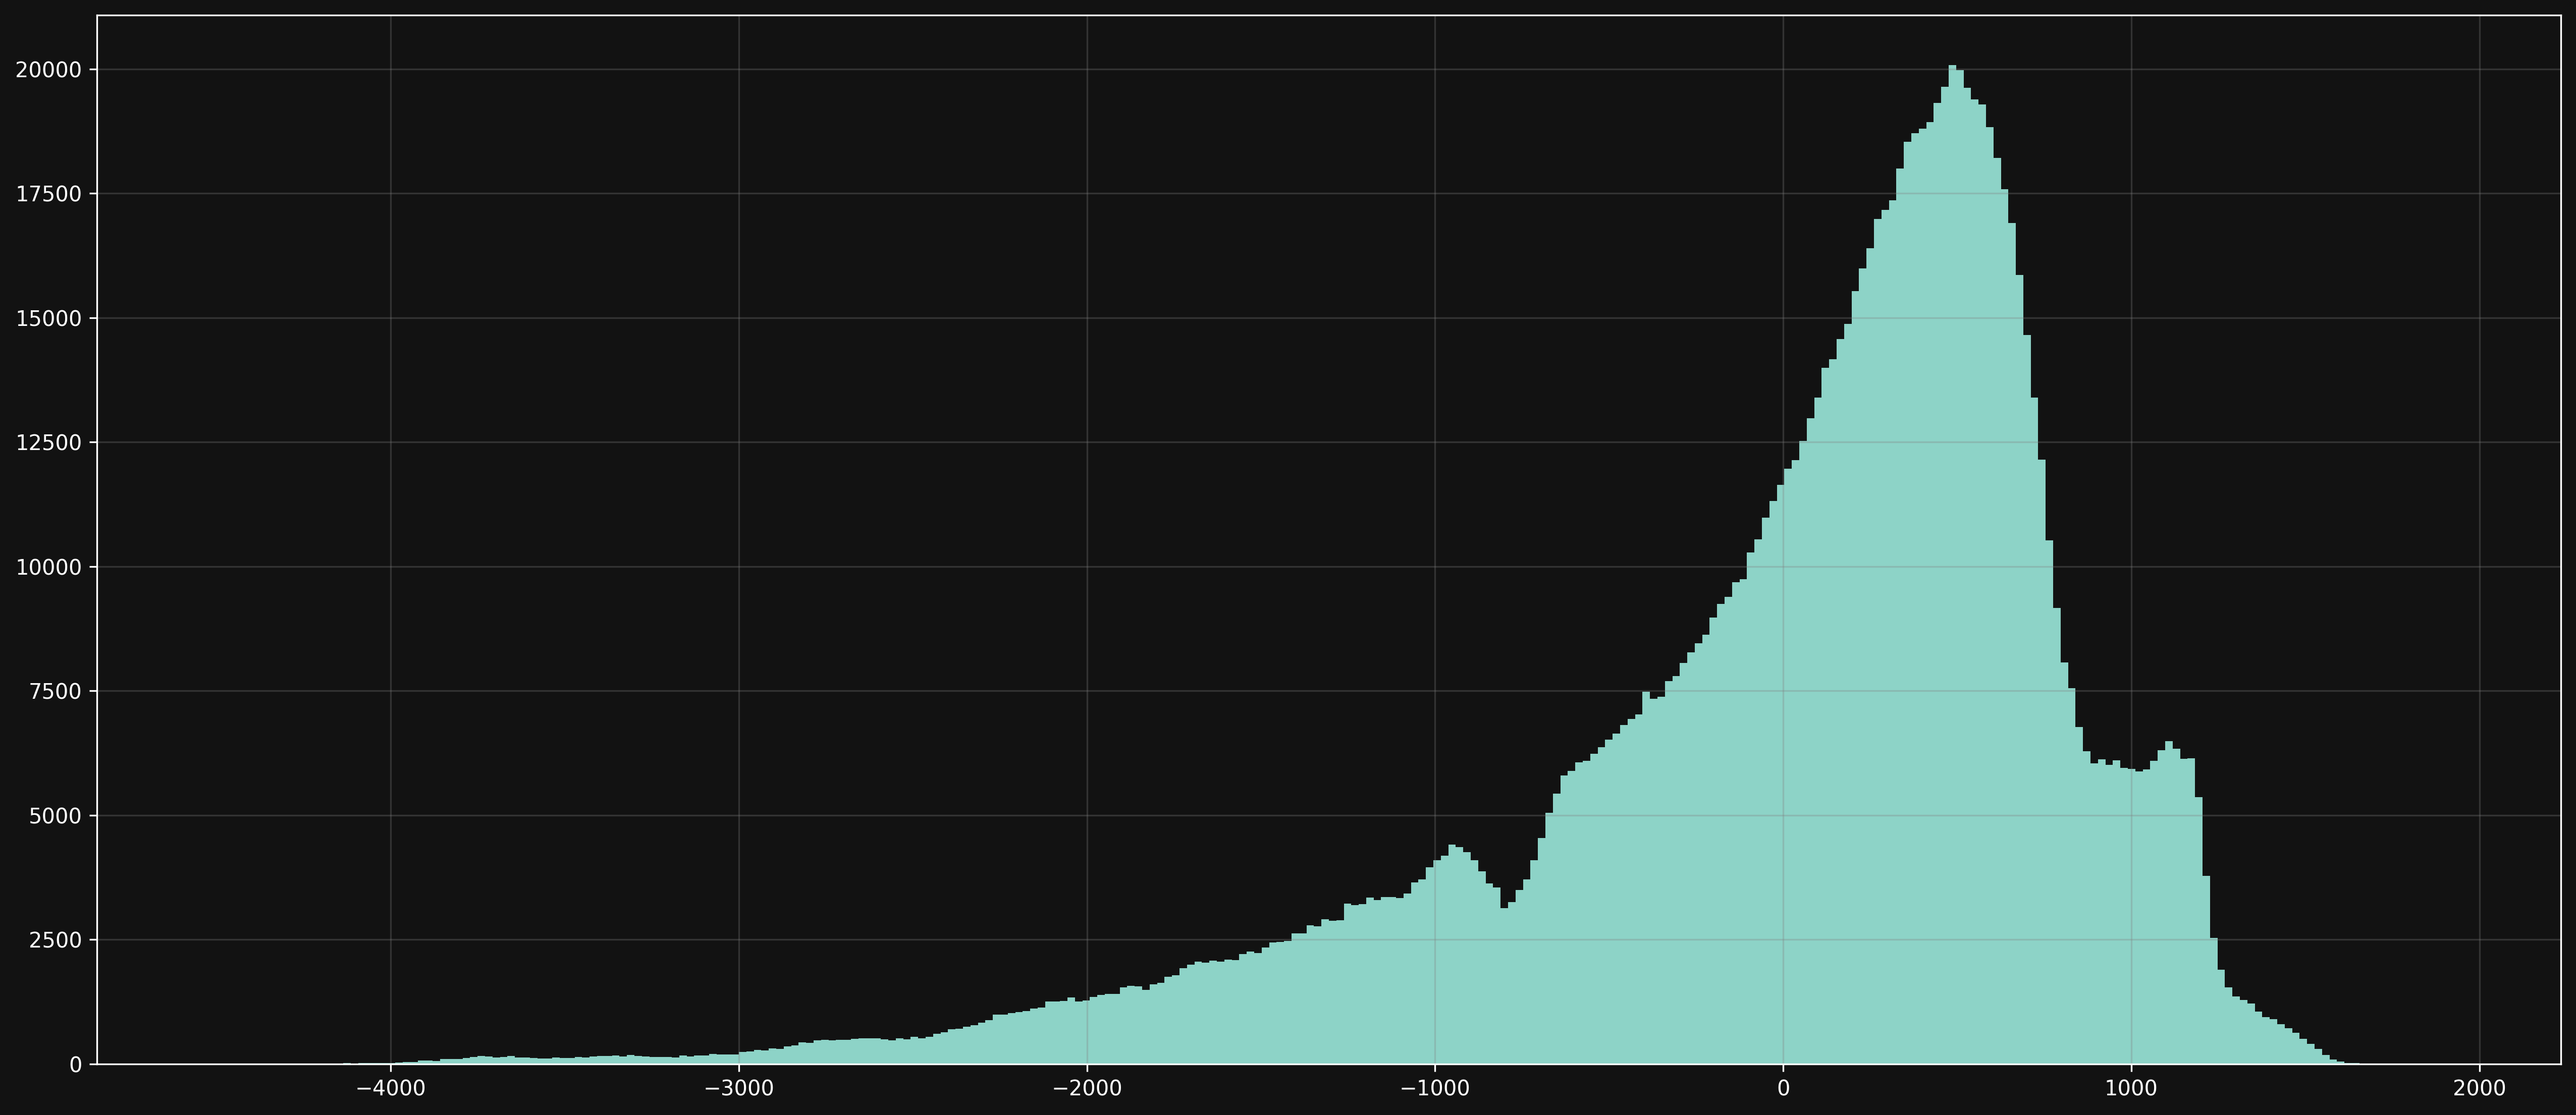

In [11]:
non_log_e = pd.Series(data[:len(y)].non_log.values - y)

gmm = GaussianMixture(n_components=7, random_state=42, init_params='random_from_data', tol=1e-4, max_iter=1000)
gmm.fit(non_log_e.values.reshape(-1, 1))

# draw three different gaussians distributions
x = np.linspace(-5000, 3000,  1000)
logprob = gmm.score_samples(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = gmm.predict_proba(x.reshape(-1, 1))
pdf_individual = pdf_individual * pdf[:, np.newaxis]

plt.fill_between(x, pdf, color='gray', alpha=0.5)
plt.plot(x, pdf, color='gray')
plt.plot(x, pdf_individual, '--k')
plt.title('Gaussian Mixture Model')
plt.show()
non_log_e.hist(bins=300)

In [12]:
# policy_start_date 피처 전처리
data['policy_start_date'] = pd.to_datetime(data['policy_start_date'])
data['policy_start_date'] = (data['policy_start_date'] - pd.to_datetime('1970-01-01')).dt.days

In [13]:
# --- 2. 결측치 처리 ---

# number_of_dependents, insurance_duration, previous_claims is categorical
data['number_of_dependents'] = data['number_of_dependents'].apply(lambda x: str(x))
data['insurance_duration'] = data['insurance_duration'].apply(lambda x: str(x))
data['previous_claims'] = data['previous_claims'].apply(lambda x: str(x))


# age to binned, vehicle_age to binned
data['age'] = pd.qcut(data['age'], q=8, duplicates='raise')
data['vehicle_age'] = pd.qcut(data['vehicle_age'], q=8, duplicates='raise')


categorical_columns = data.select_dtypes(include=['object', 'category']).columns
ordinal_categories = pd.Index(['age', 'vehicle_age', 'number_of_dependents', 'insurance_duration', 'previous_claims'])
categorical_columns = categorical_columns.drop(ordinal_categories)

# 범주형 변수의 결측치를 'unknown'으로 대체
for col in categorical_columns:
    data[col].fillna('unknown', inplace=True)


# 수치형 변수의 결측치를 최대값 + 10%로 대체
float_columns = data.select_dtypes(include=['float64']).columns
for col in float_columns:
    data[col].fillna(data[col].max() * 1.1, inplace=True)
    
int_columns = data.select_dtypes(include=['int64']).columns
for col in int_columns:
    data[col].fillna(data[col].max()+int(data[col].std()), inplace=True)
numerical_columns = float_columns.append(int_columns)

# --- 3. 범주형 변수 인코딩 및 수치형 스케일링 ---
# 범주형 변수 인코딩
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
    
    
# 순서 범주형 변수 인코딩
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1)
data[ordinal_categories] = ordinal_encoder.fit_transform(data[ordinal_categories])
categorical_columns = categorical_columns.append(ordinal_categories)
# 수치형 변수 스케일링
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# y 스케일링

y_scaler = StandardScaler()
y_scaler.fit(np.log1p(y).reshape(-1,1))
# y_scaler_torch = TorchStandardScaler()
# y_scaler_torch.fit(torch.tensor(torch.log1p(torch.tensor(y, dtype=torch.float32).to(device)).squeeze(-1)))
y = y_scaler.transform(np.log1p(y).reshape(-1,1)).reshape(-1)

data[target_column] = np.pad(y, (0, data.shape[0]-len(y)), 'constant', constant_values=np.nan)

X = data[:len(y)].drop(columns=target_column).copy()
test_data = data[data[target_column].isna()].drop(columns=[target_column])
y_val_origin = data[target_column].values[:len(y)]

# Devide Dataset

In [24]:
# drop features: 'policy_type', 'location', 'property_type', 'smoking_status', 'gender'

# X = data.loc[data[target_column].notnull(), ].drop(columns=[target_column, 'policy_type', 'location', 'property_type', 'smoking_status', 'gender'])

<Axes: >

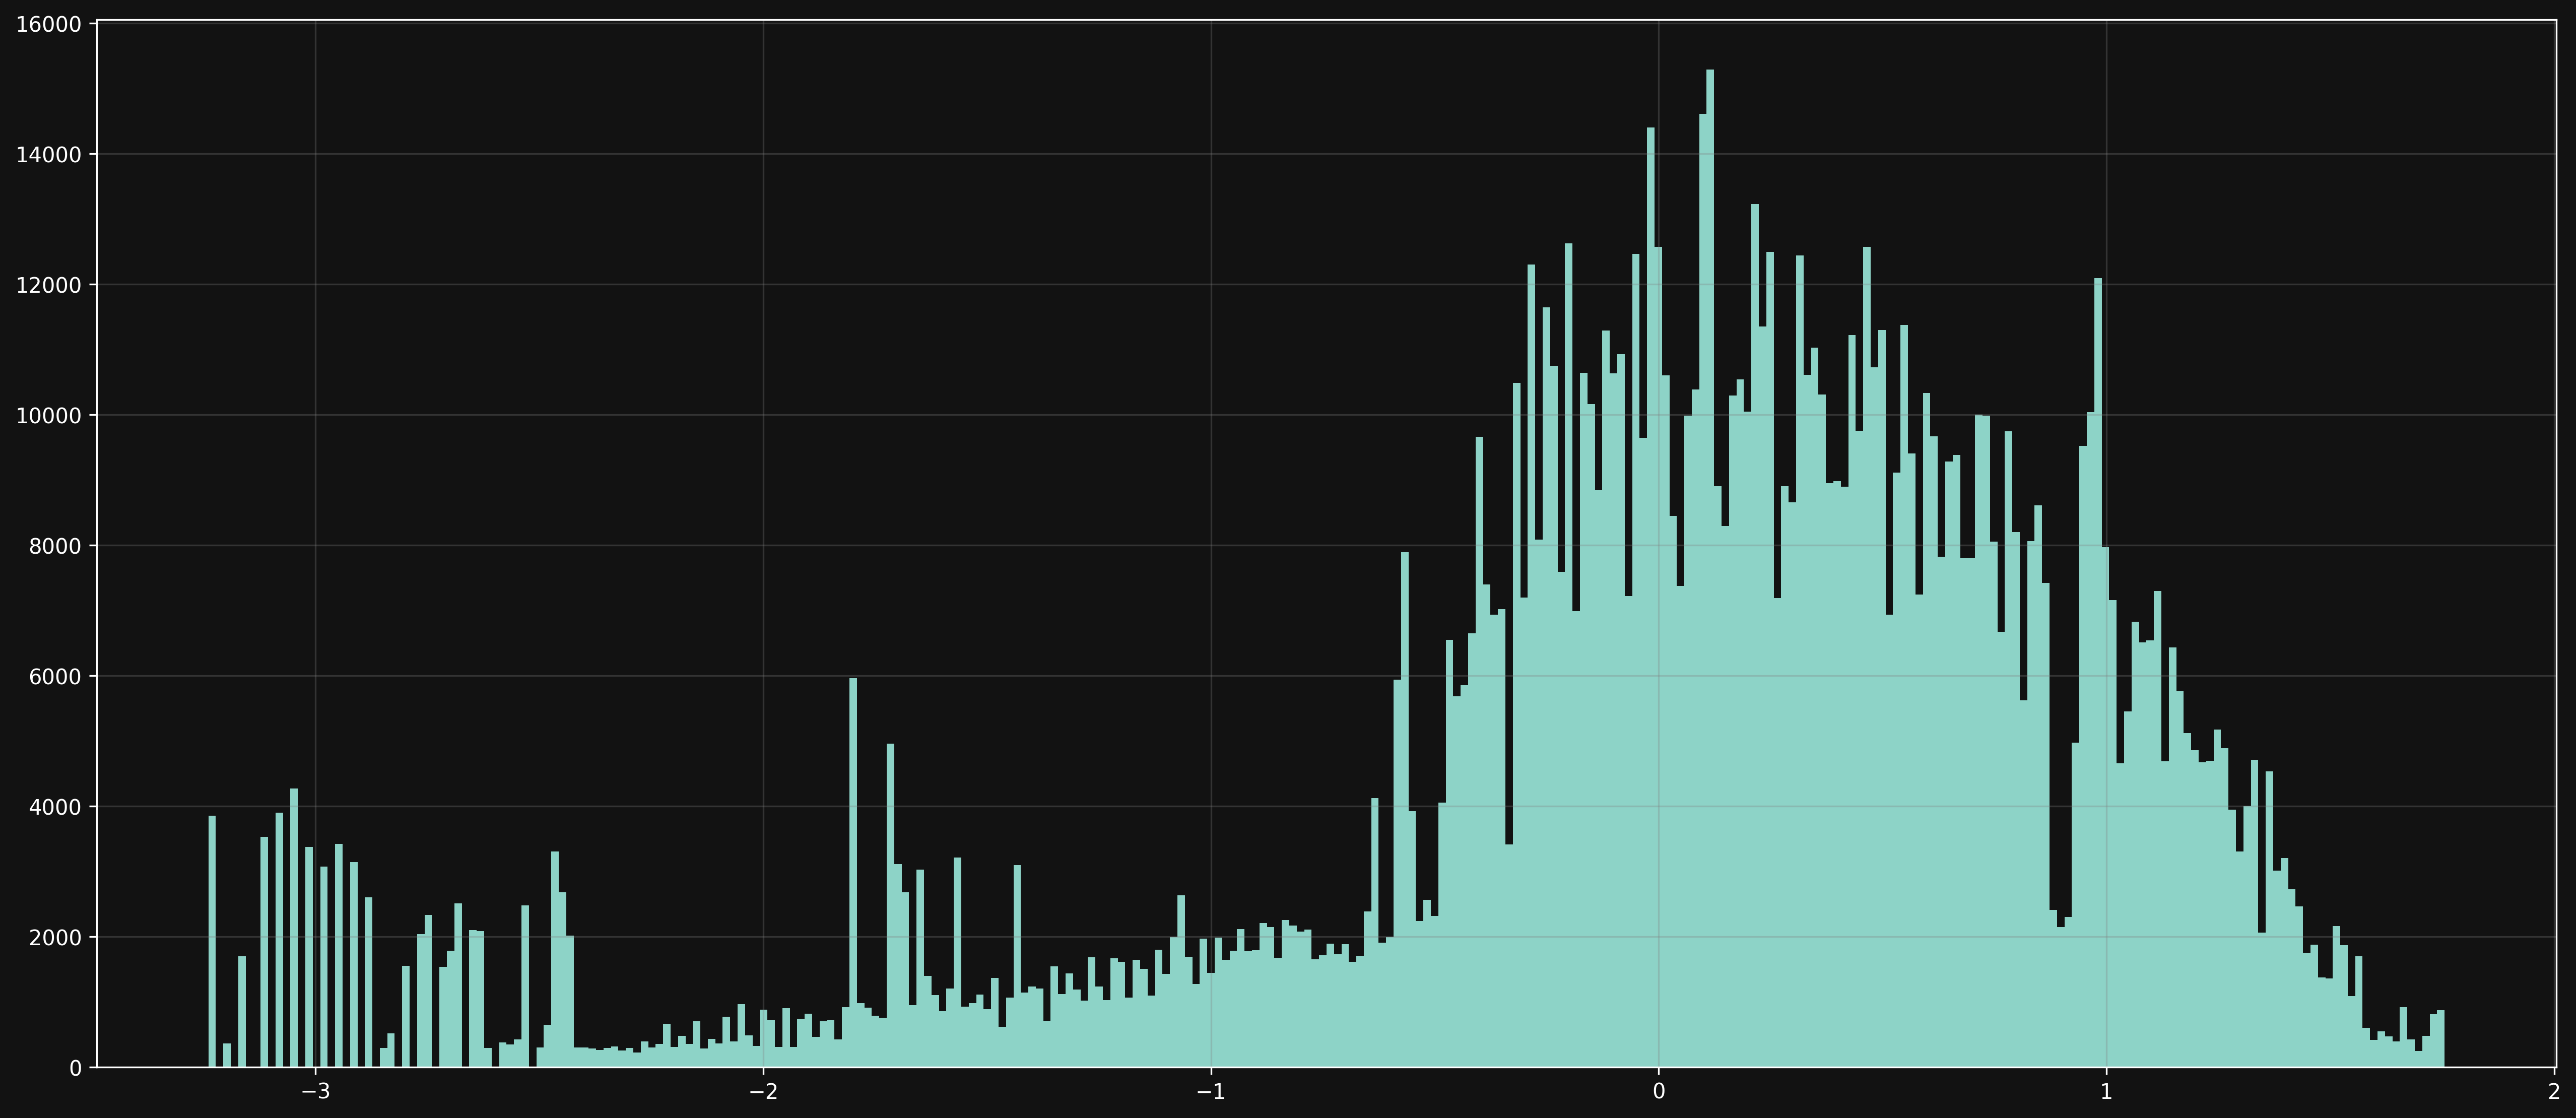

In [60]:
pd.Series(y).hist(bins=300)

In [14]:
def inverse_y(y):
    return np.expm1(y_scaler.inverse_transform(y.reshape(-1,1)).reshape(-1))

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X.values, y, test_size=0.2, random_state=42)

# Modeling

In [16]:
from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    
    
    y_pred = inverse_y(y_pred)
    y_val = inverse_y(y_val)
    
    rmsle = mean_squared_log_error(y_val, y_pred) ** (1/2)
    return r2, mse, rmsle

def evaluate_model_no_inverse(model, X_val, y_val):
    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    # y_pred = inverse_y(y_pred)
    # y_val = inverse_y(y_val)
    rmsle = mean_squared_log_error(y_val, y_pred) ** (1/2)
    return r2, mse, rmsle

In [70]:
# TODO: LightGBM Regressor

lgbm = LGBMRegressor(
    # **{
    #     'n_estimators': 904,
    #     'learning_rate': 0.22397849703318146,
    #     'max_depth': 6,
    #     'reg_lambda': 1.0772060124044087,
    #     'subsample': 0.7276099887947944,
    #     'subsample_freq': 1,
    #     'min_child_samples': 12
    # },
    
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=500,
    max_depth=20,
    learning_rate=0.1,
    
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    gpu_id=0,
    device_type='gpu',
)

lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)])

LGBMRegressor(device_type='gpu', gpu_id=0, max_depth=20, min_child_samples=7,
              min_child_weight=0.003, n_estimators=500, n_jobs=-1,
              random_state=42, verbosity=-1)

In [39]:
rmlse(np.expm1(lgbm.predict(X_val)), np.expm1(y_val))

('RMLSE', 1.032243106972295, False)

In [71]:
evaluate_model(lgbm, X_val, y_val) # non_log_with_simpler_date

(0.11377881390272249, 0.8871729260698745, 1.0321552876695002)

In [30]:
evaluate_model(lgbm, X_val, y_val)

(0.10041606821976368, 0.9005500224131534, 1.0399077683210711)

In [87]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models= []
oof_preds = np.zeros(X.shape[0])
for train_idx, val_idx in kf.split(X):
    X_train, _X_val = X.values[train_idx], X.values[val_idx]
    y_train, _y_val = y[train_idx], y[val_idx]
    lgbm = LGBMRegressor(
    # **{
    #     'n_estimators': 904,
    #     'learning_rate': 0.22397849703318146,
    #     'max_depth': 6,
    #     'reg_lambda': 1.0772060124044087,
    #     'subsample': 0.7276099887947944,
    #     'subsample_freq': 1,
    #     'min_child_samples': 12
    # },
    
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=500,
    max_depth=20,
    learning_rate=0.1,
    
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    gpu_id=0,
    device_type='gpu',
)
    lgbm.fit(X_train, y_train, eval_set=[(_X_val, _y_val)])
    models.append(lgbm)
    pred = lgbm.predict(_X_val)
    oof_preds[val_idx] = pred
    print(evaluate_model(lgbm, _X_val, _y_val))
del _X_val, _y_val

(0.11344812006720373, 0.8875039750475938, 1.0323478443137144)
(0.1124926719661914, 0.8865096330434379, 1.0317693711270786)
(0.10927510966179543, 0.8895044432828086, 1.033510665376858)
(0.11527349123908814, 0.8843836589412031, 1.0305314648771844)
(0.1133304219818222, 0.8882391868995831, 1.032775356340944)


In [77]:
test_data
ps = []

for model in models:
    ps.append(model.predict(test_data))


array([2869., 1483.,  567., ...,  371.,  596., 2480.])

<Axes: >

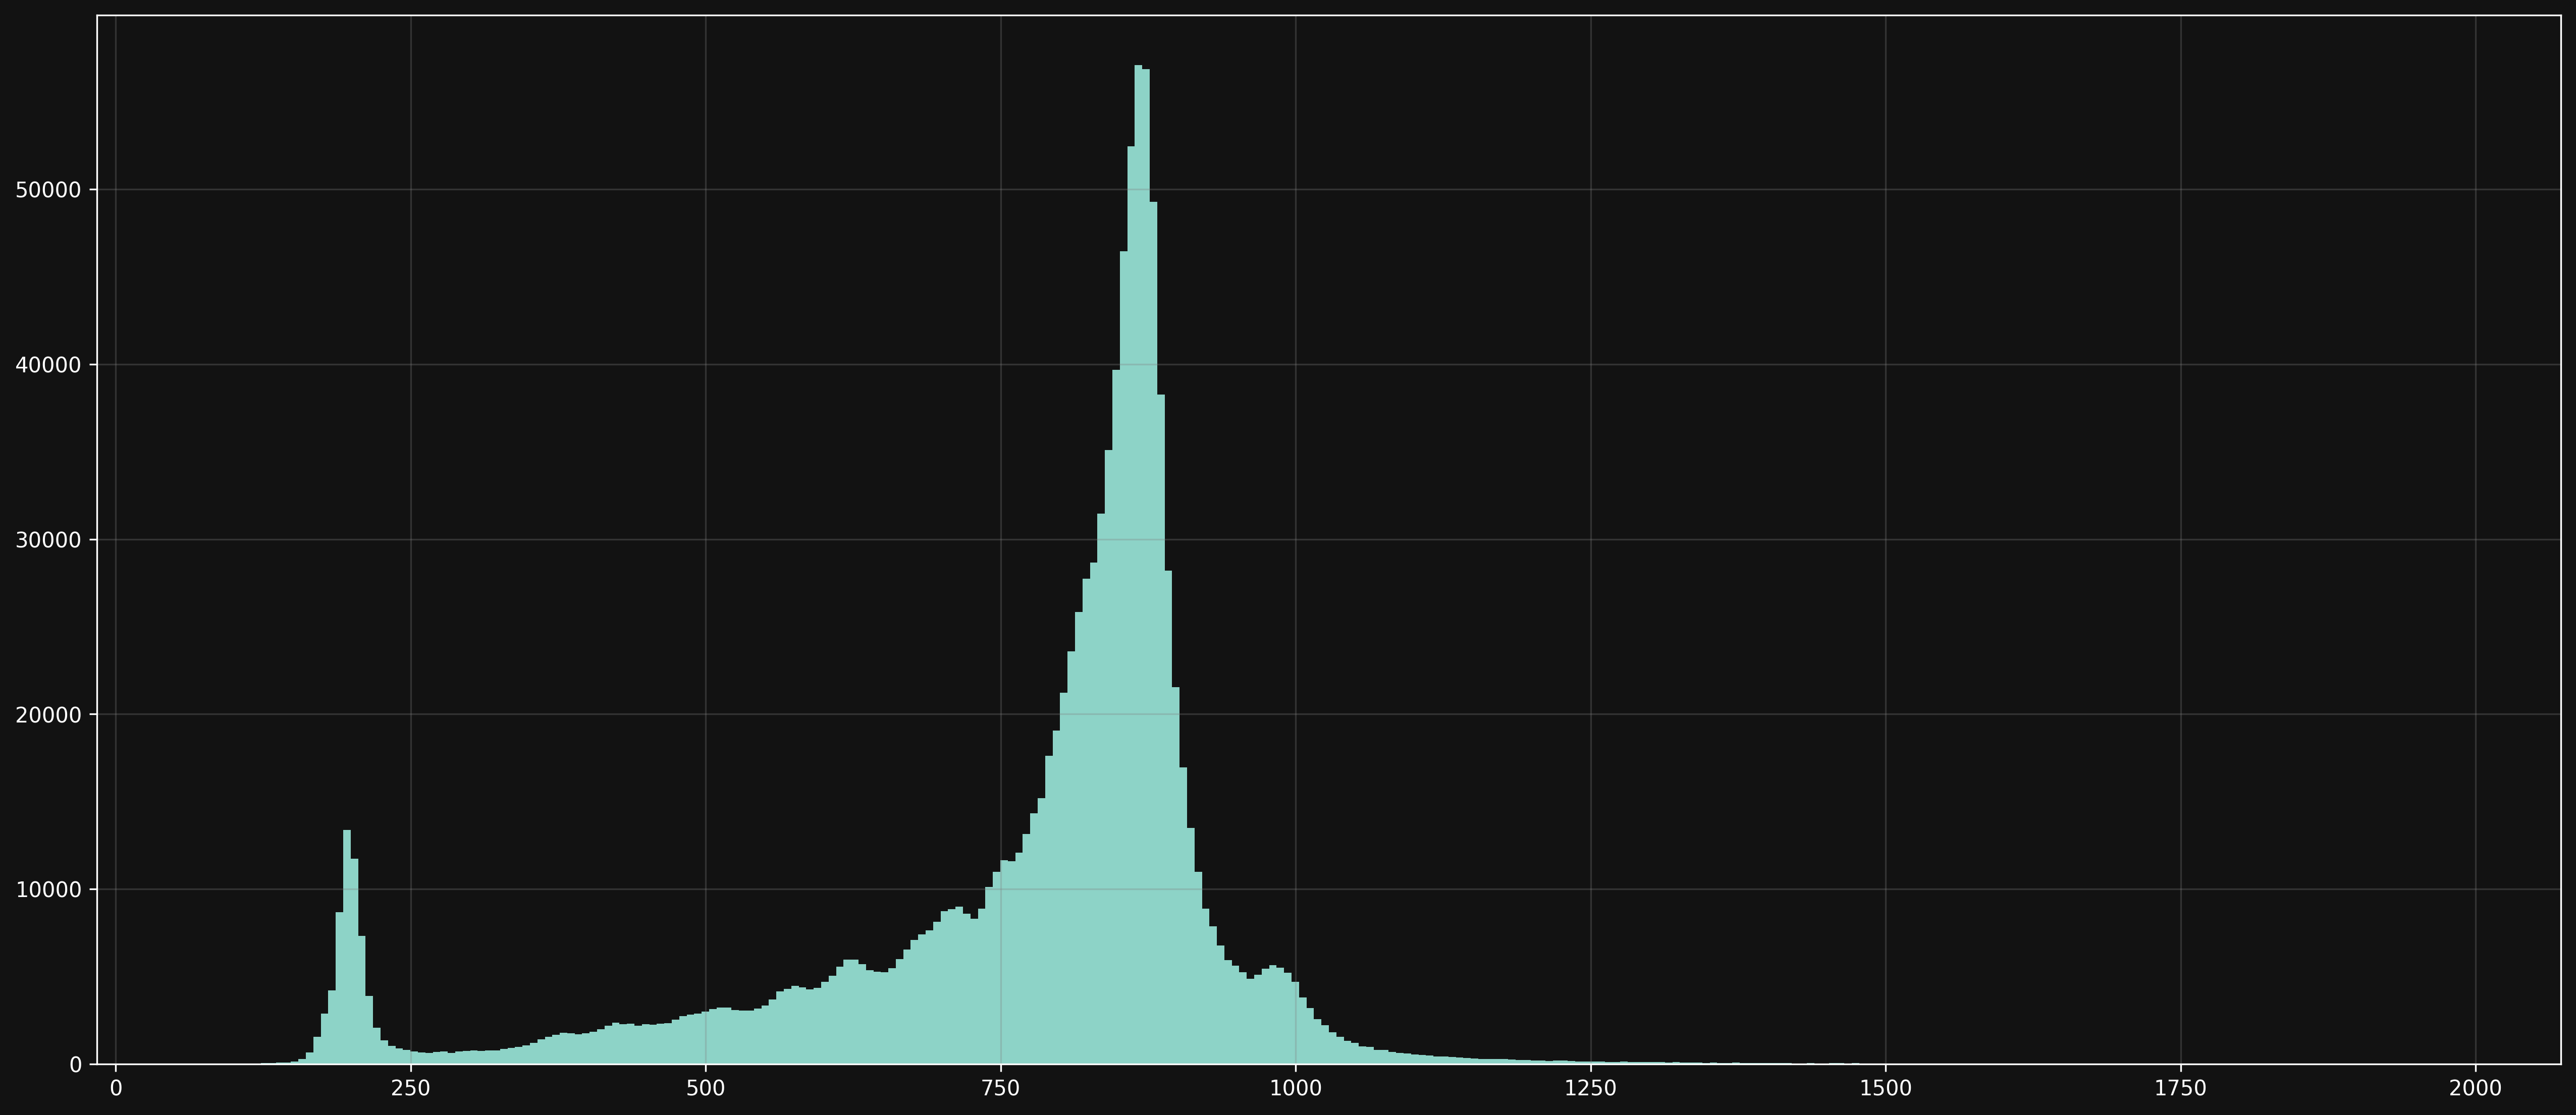

In [97]:
pd.Series(inverse_y(oof_preds)).hist(bins=300)

In [101]:
pd.Series(inverse_y(X.non_log.values)).max()

21303647.8780094

In [109]:
mean_squared_log_error(np.array([1.2,2,3]), np.array([1,2,3]))

0.0030280101247775796

<Axes: >

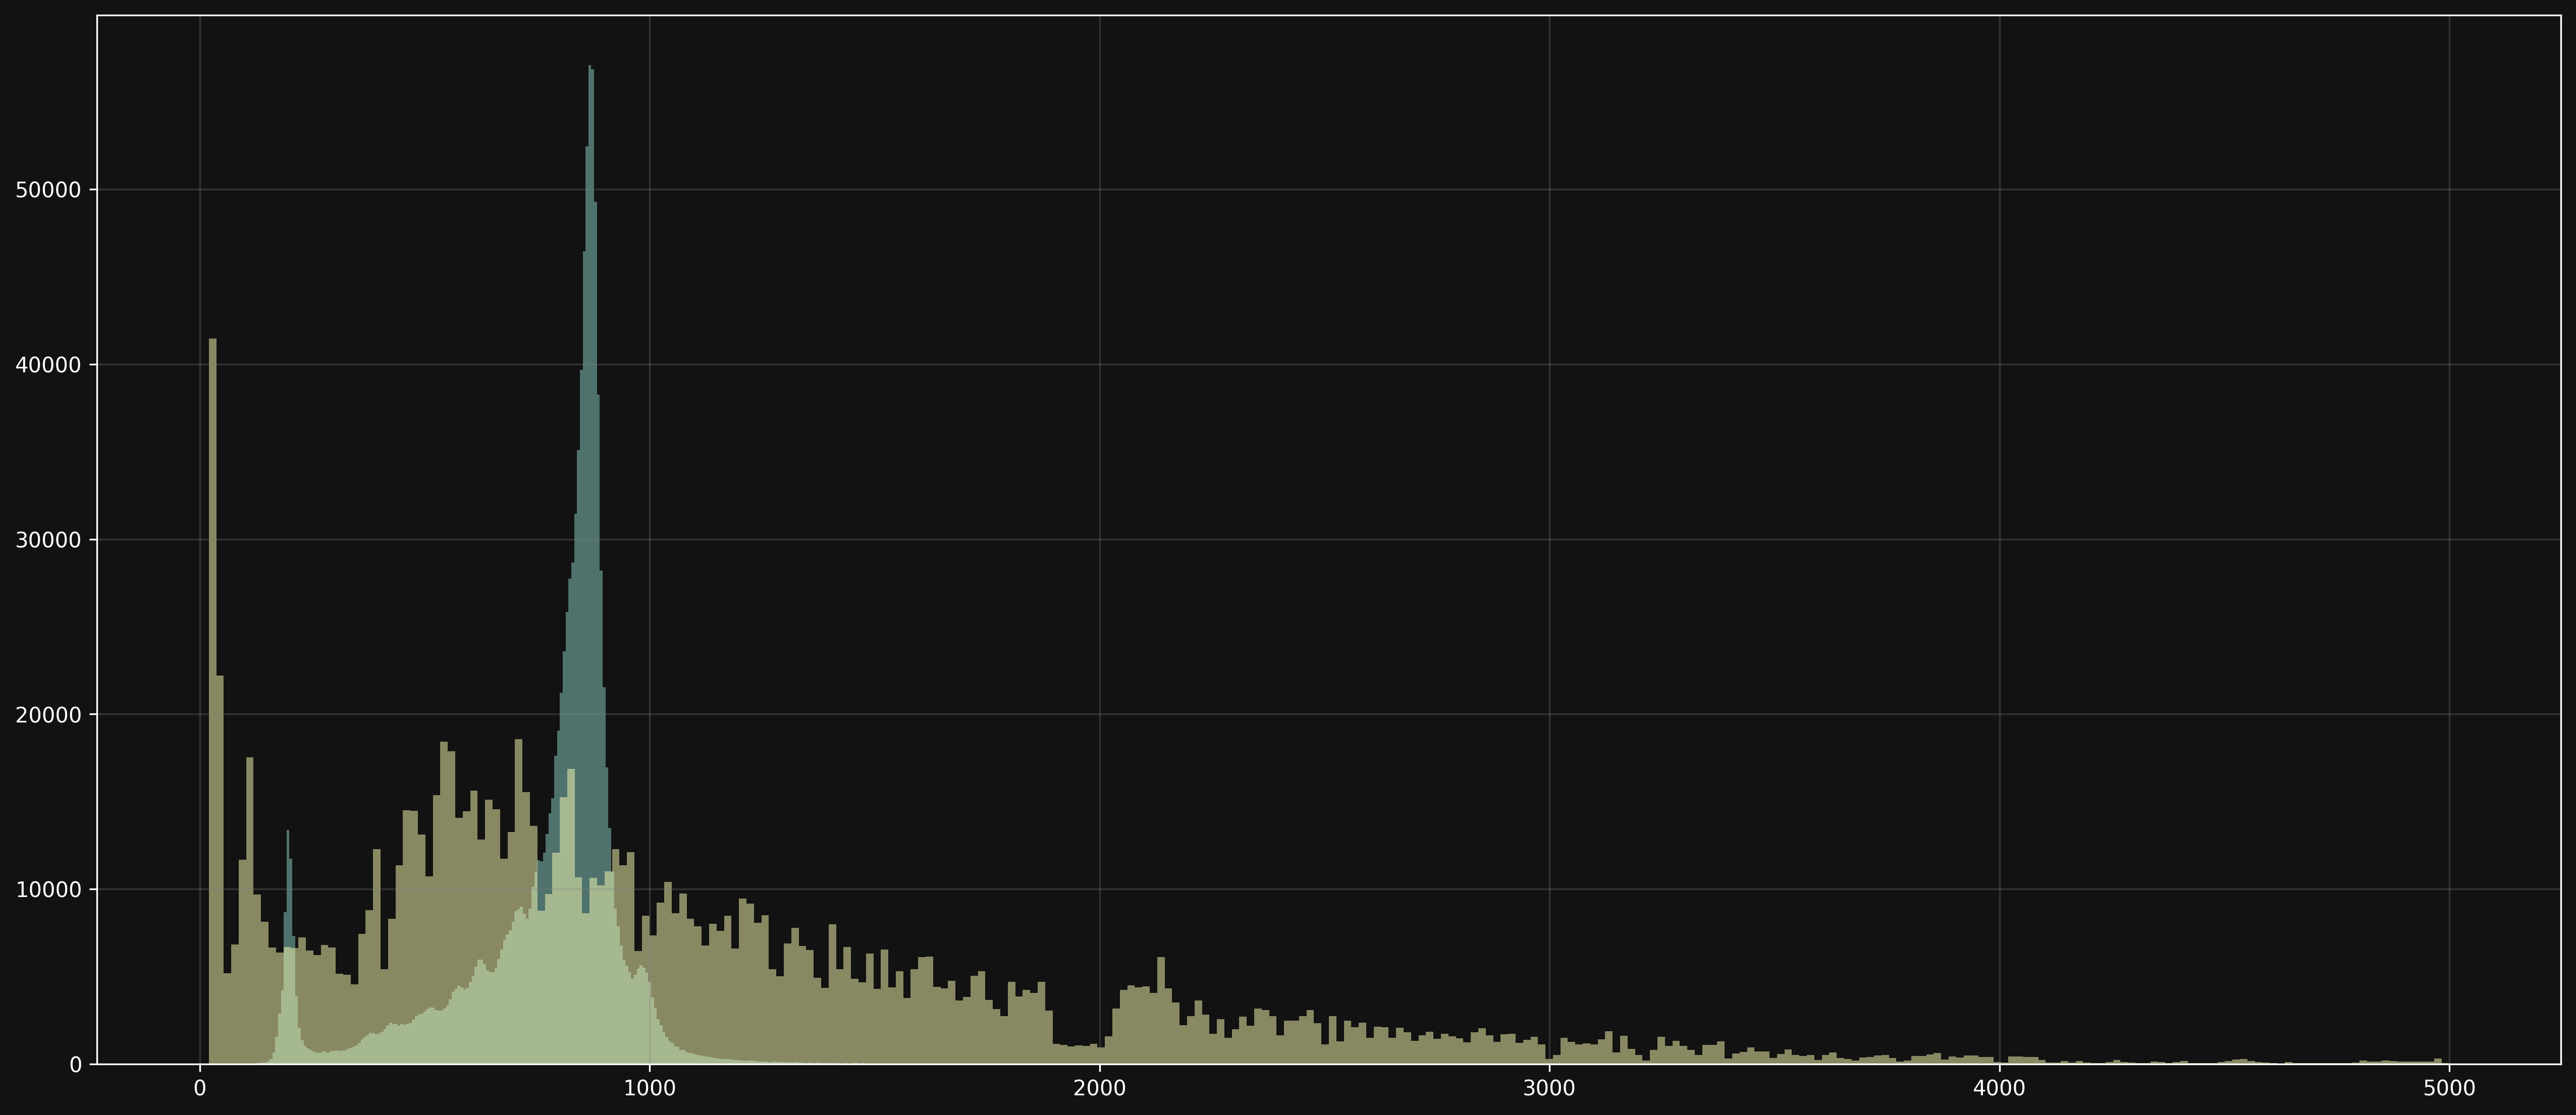

In [102]:
pd.Series(inverse_y(oof_preds)).hist(bins=300, alpha=0.5)
# pd.Series(inverse_y(X.non_log.values)).hist(bins=300, alpha=0.5)
pd.Series(inverse_y(y)).hist(bins=300, alpha=0.5)

<Axes: >

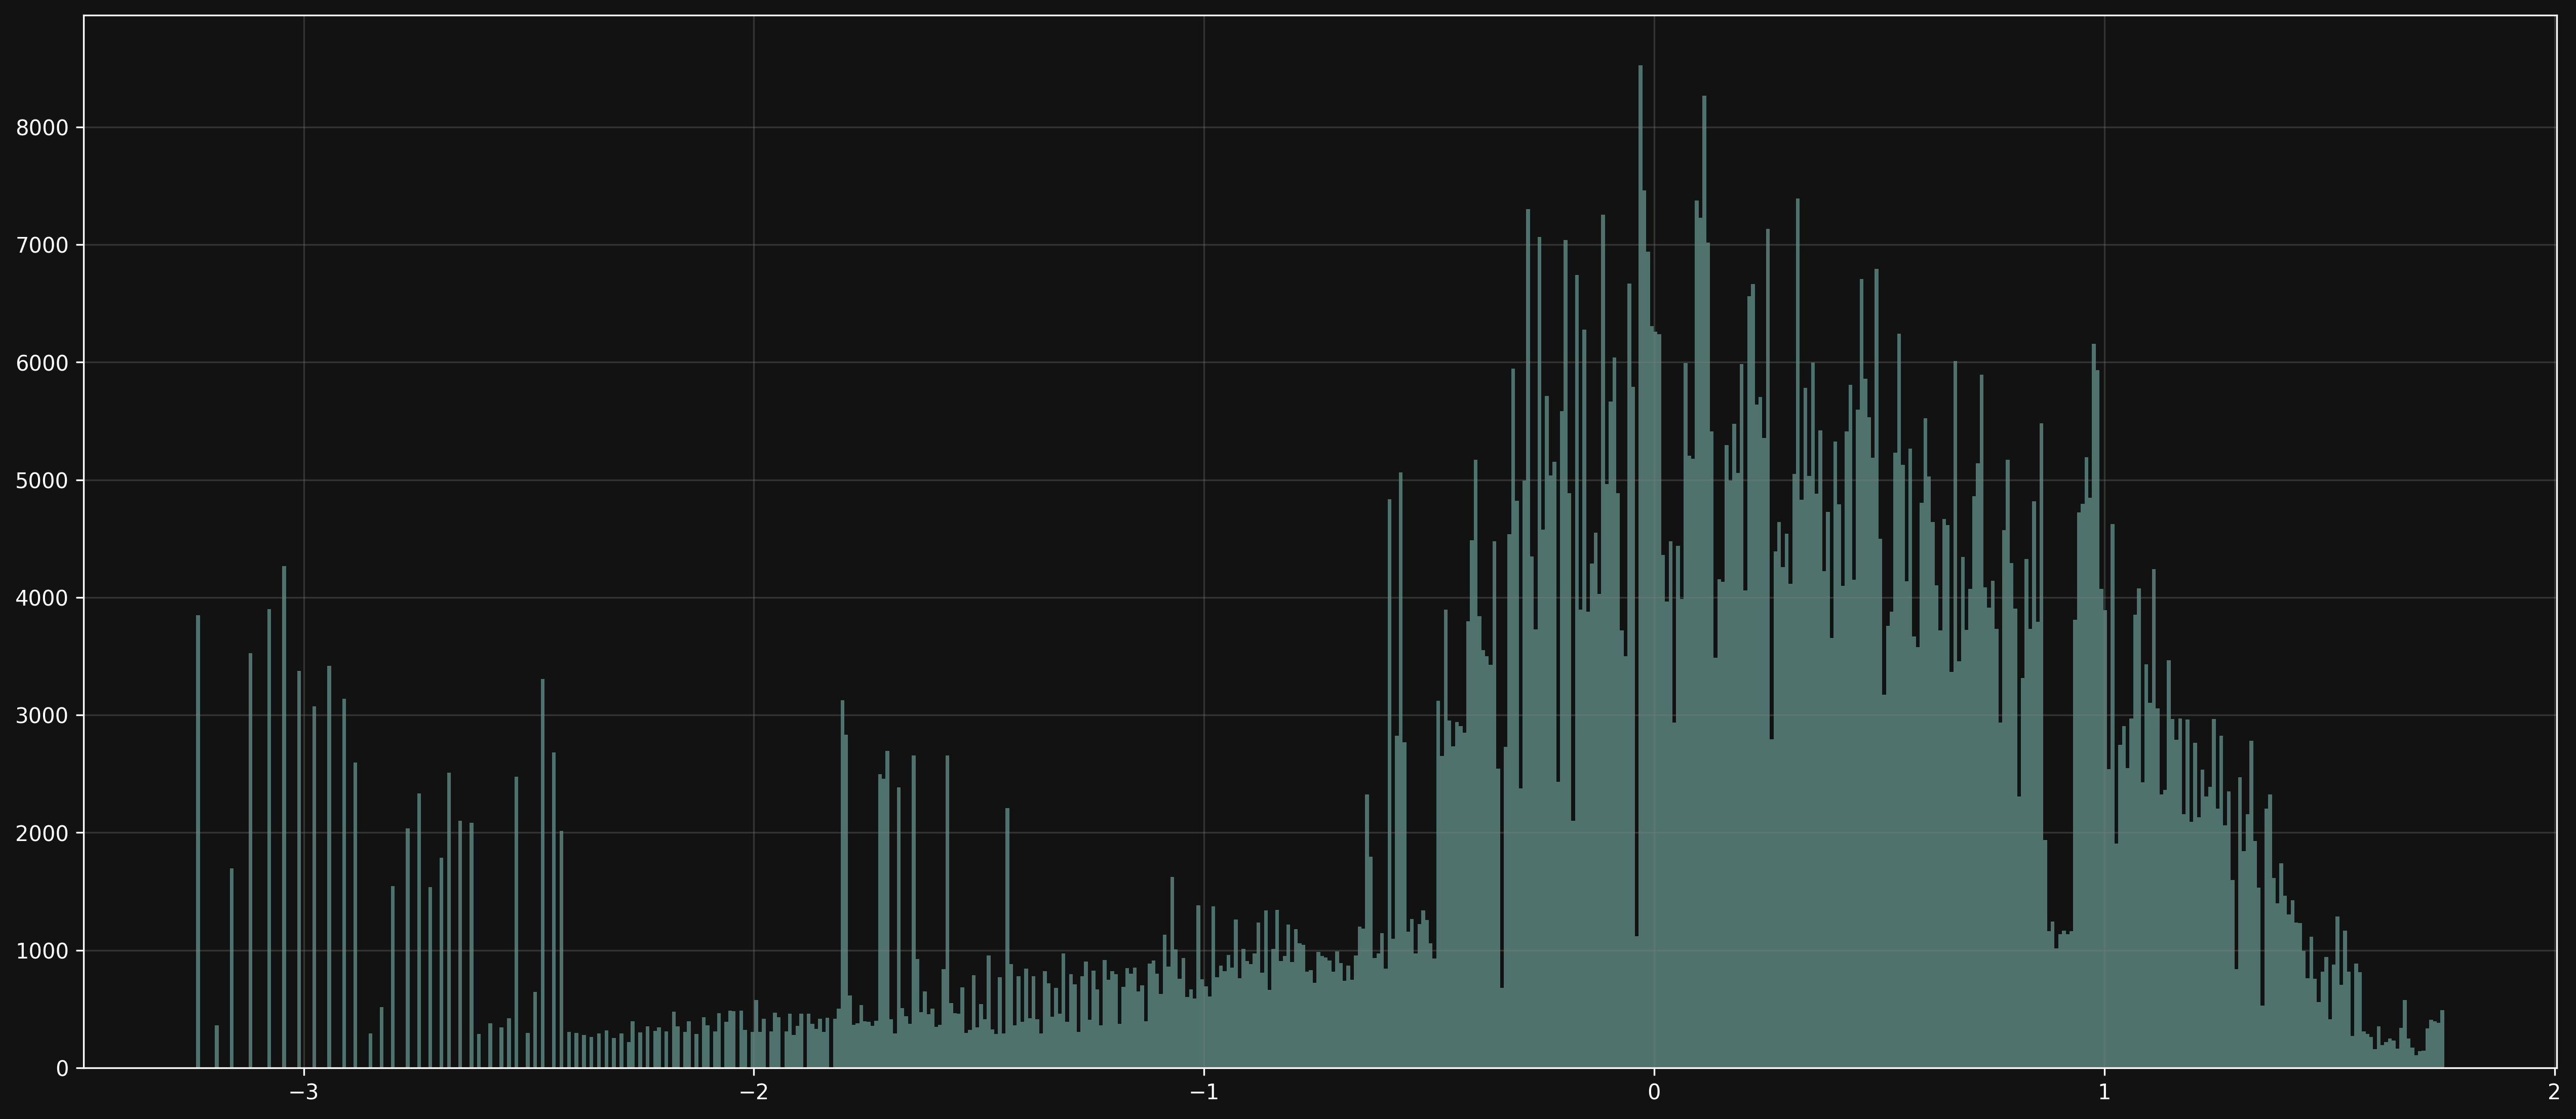

In [18]:
y_val_origin_ser = pd.Series(y_val_origin)
y_val_origin_ser.hist(bins=600, alpha=0.5)
# for cut in pd.qcut(y_val_origin_ser, q=8, duplicates='raise').unique():
#     plt.axvline(cut.left, color='r')

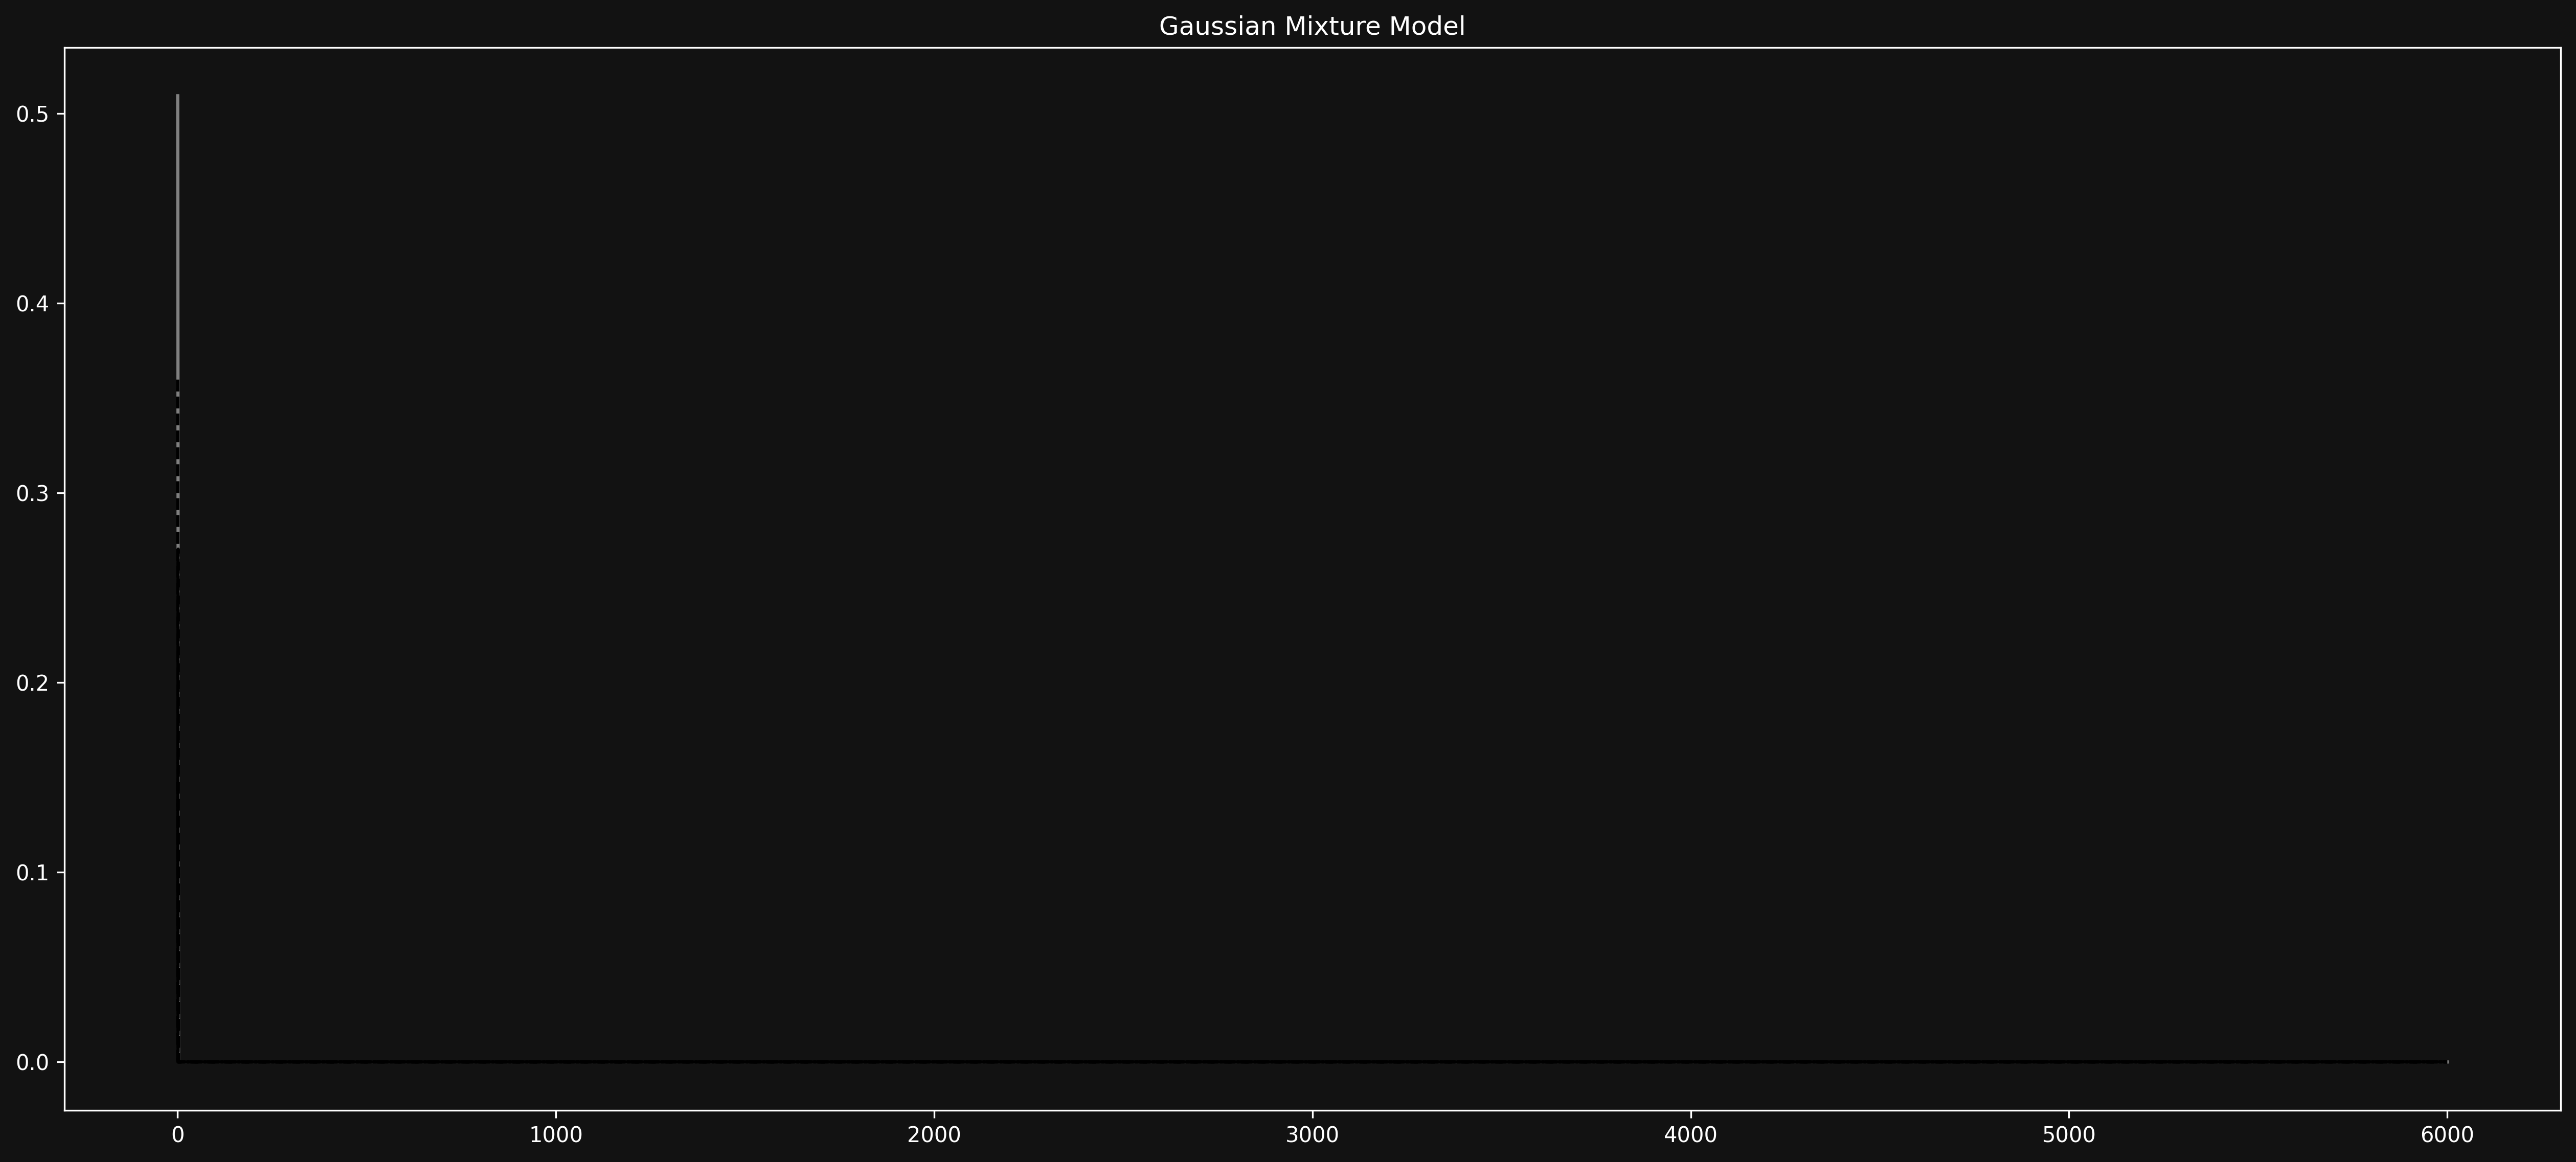

<Axes: >

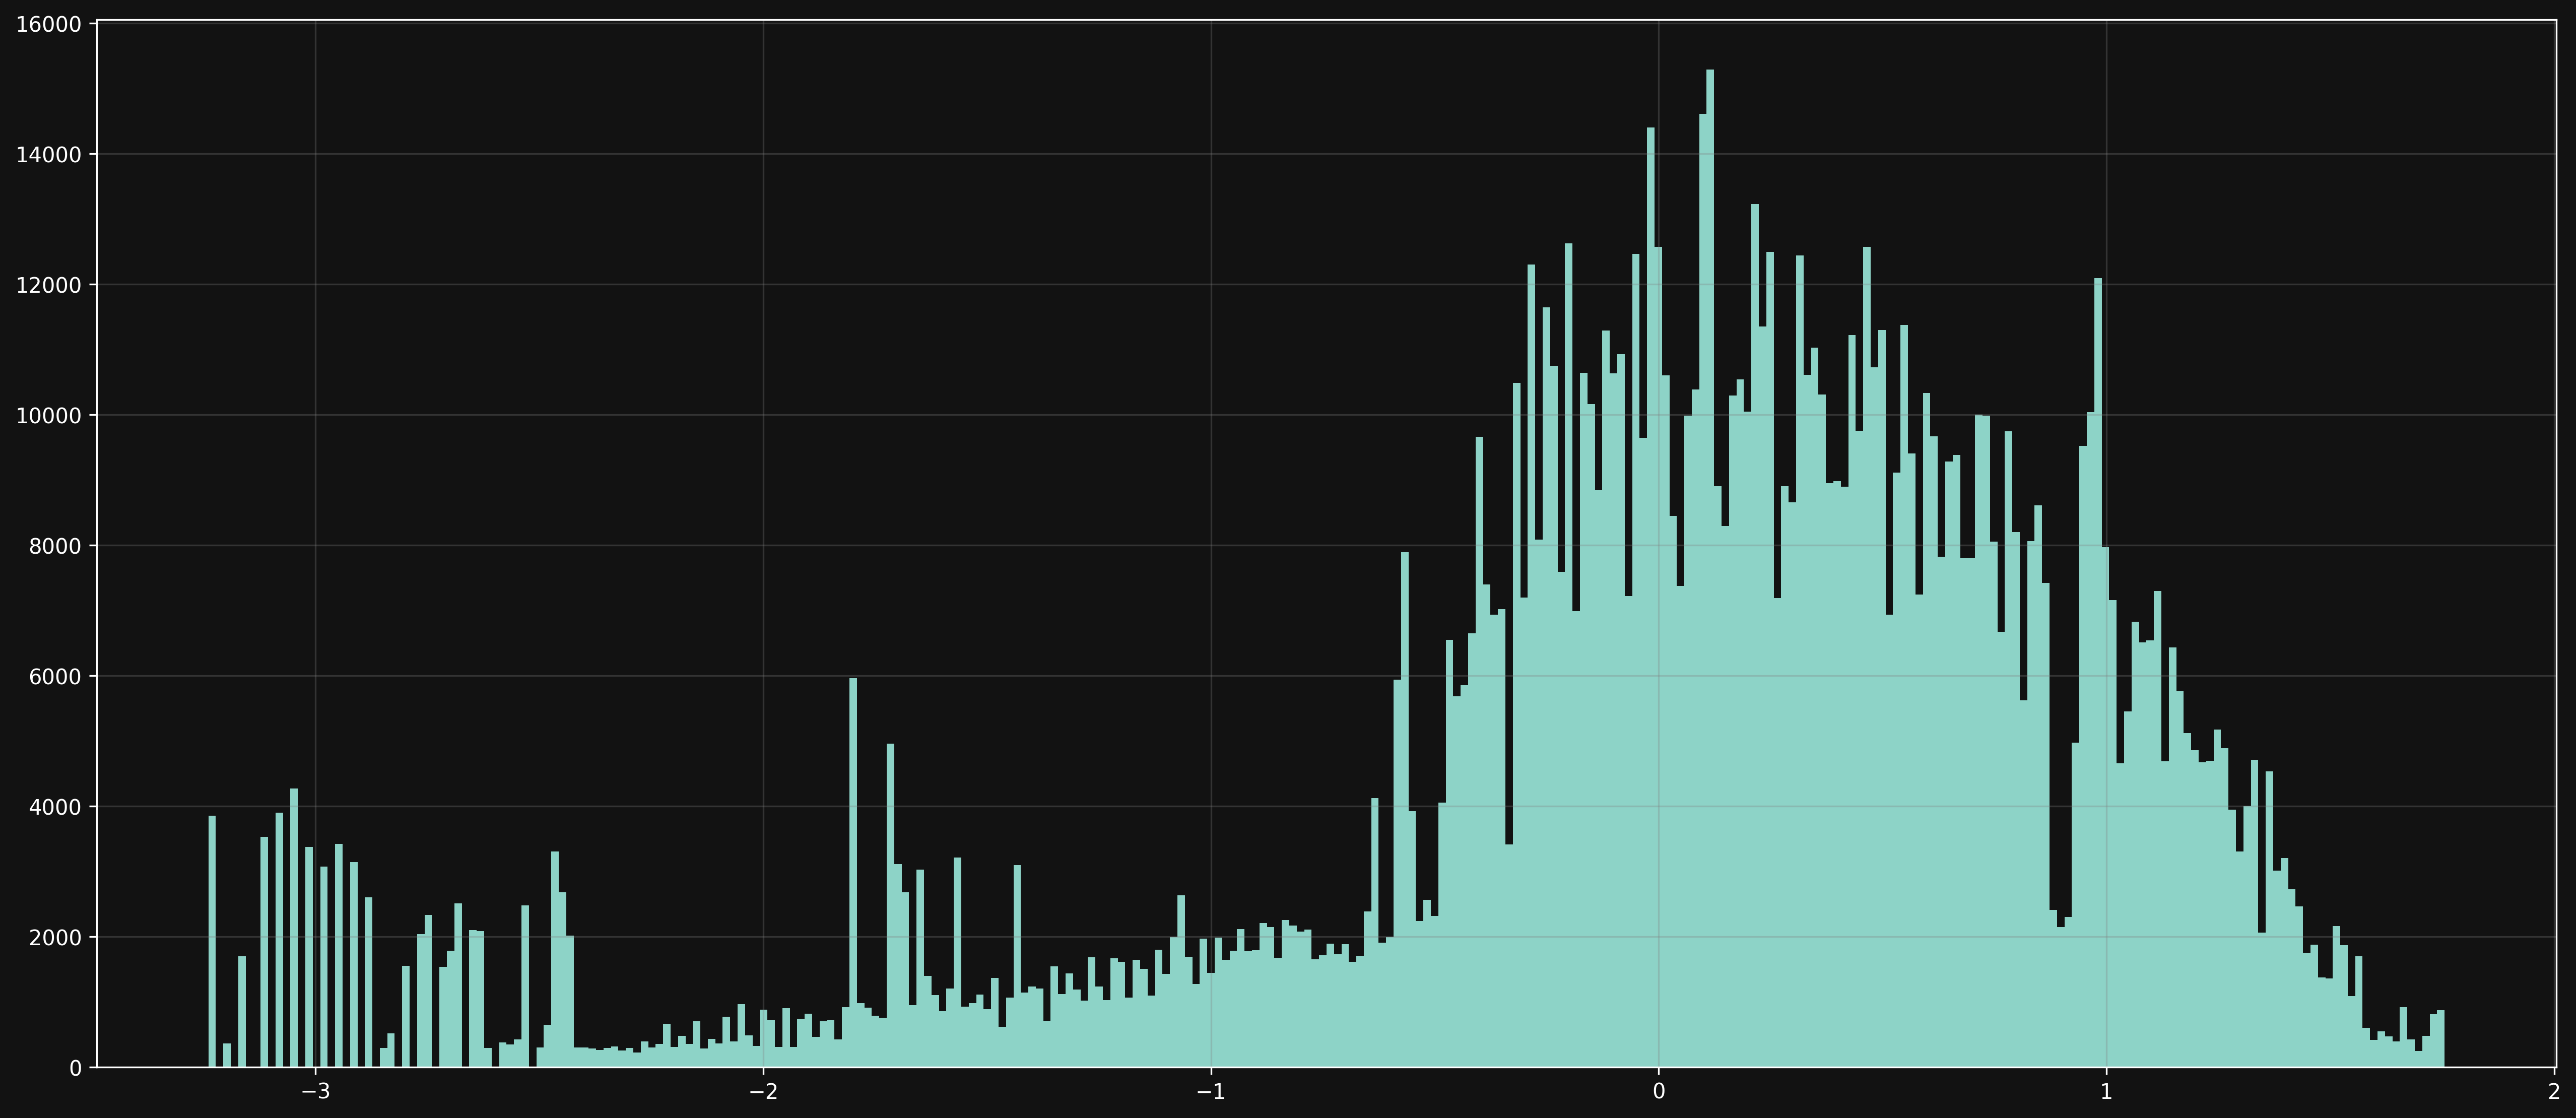

In [25]:
CLUSTER_NUM = 5
gmm = GaussianMixture(n_components=CLUSTER_NUM, random_state=42, init_params='kmeans', tol=1e-3, max_iter=100 )
gmm.fit(y_val_origin_ser.values.reshape(-1, 1))

# draw three different gaussians distributions
x = np.linspace(-0, 6000,  5000)
logprob = gmm.score_samples(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = gmm.predict_proba(x.reshape(-1, 1))
pdf_individual = pdf_individual * pdf[:, np.newaxis]

plt.fill_between(x, pdf, color='gray', alpha=0.5)
plt.plot(x, pdf, color='gray')
plt.plot(x, pdf_individual, '--k')
plt.title('Gaussian Mixture Model')
plt.show()
y_val_origin_ser.hist(bins=300)

<Axes: >

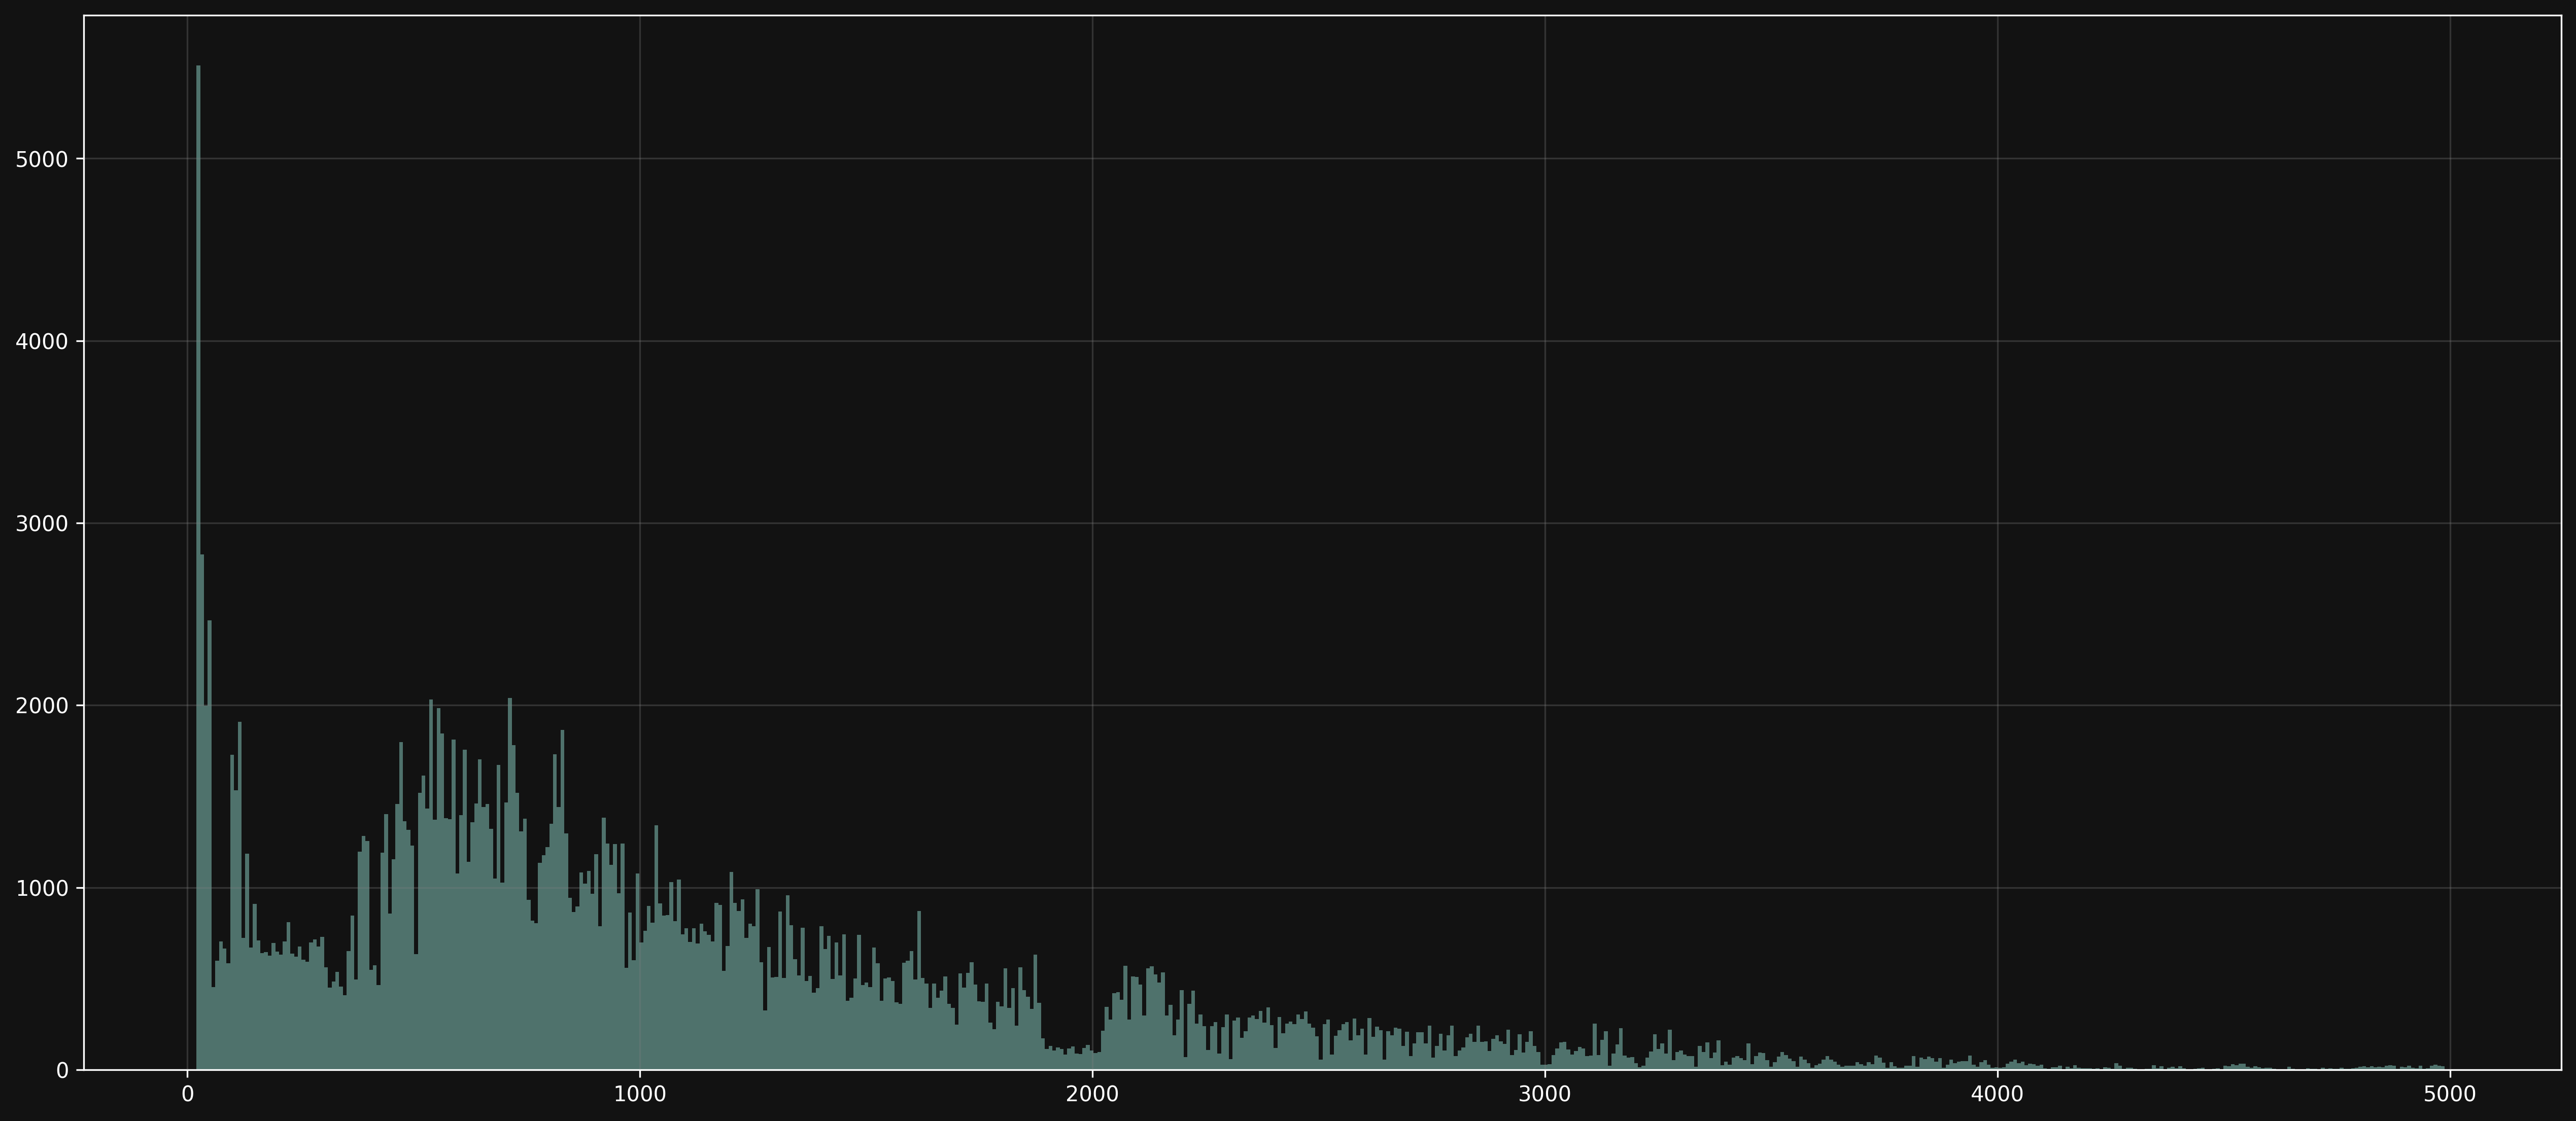

In [114]:
y_val_origin_ser.hist(bins=600, alpha=0.5)

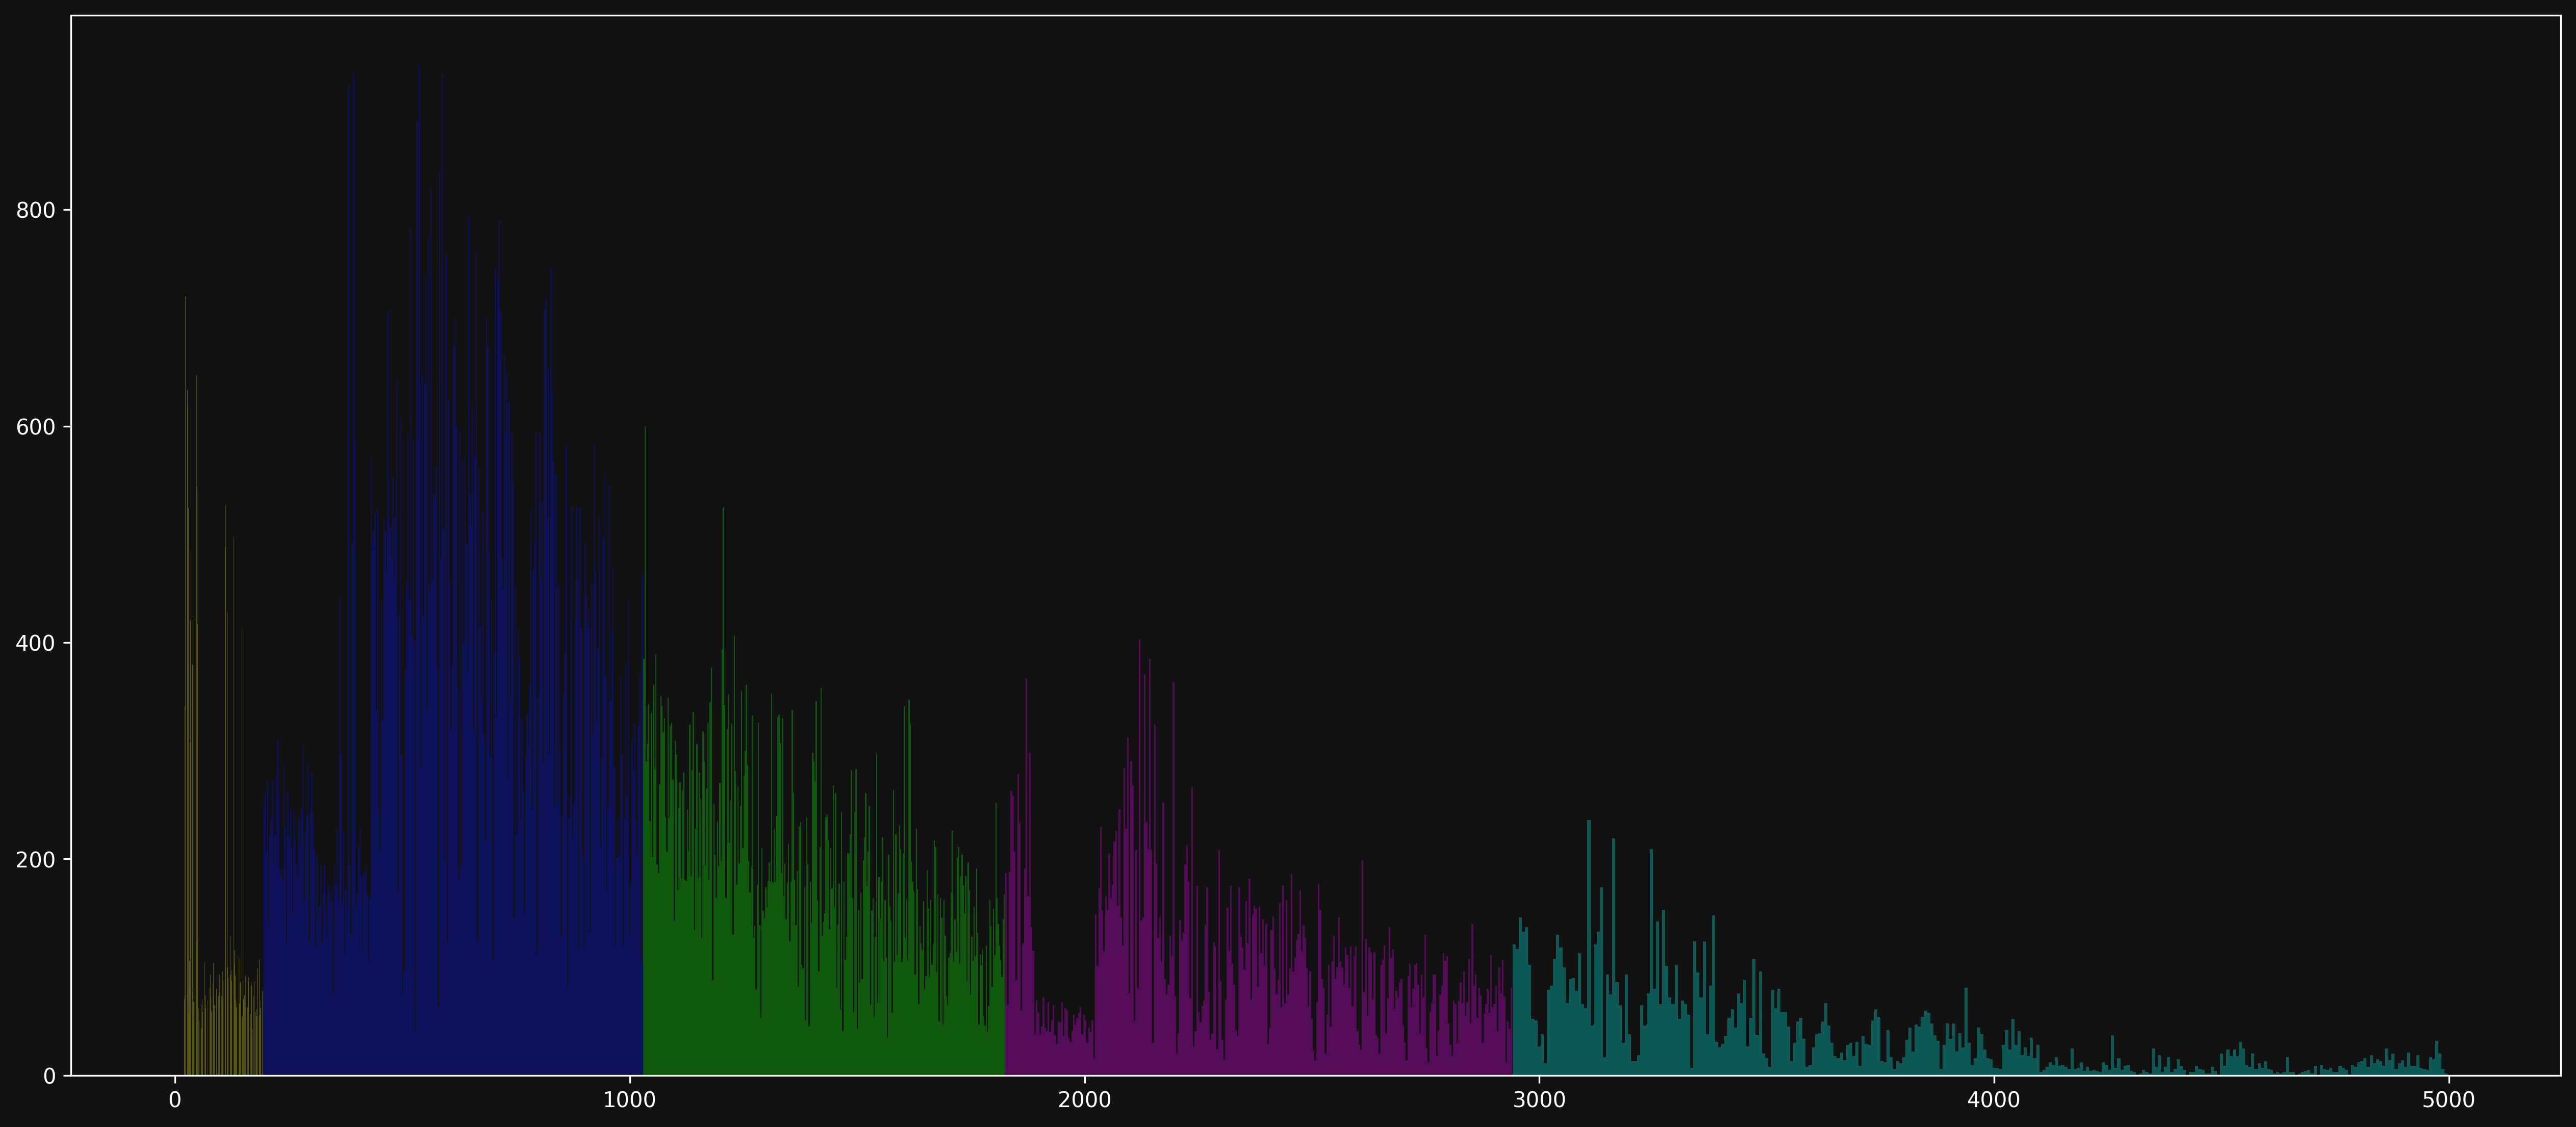

In [137]:
y_with_cluster = y_val_origin_ser.copy().rename('y').to_frame()
y_with_cluster['cluster'] = gmm.predict(y_val_origin_ser.values.reshape(-1, 1))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
pallete = sns.color_palette('hsv', CLUSTER_NUM)
for cluster in y_with_cluster.cluster.unique():
    ax.hist(y_with_cluster[y_with_cluster.cluster == cluster].y.rename(str(cluster)), bins=300, alpha=0.3, color=pallete[int(cluster)])
plt.legend
plt.show()

<Axes: >

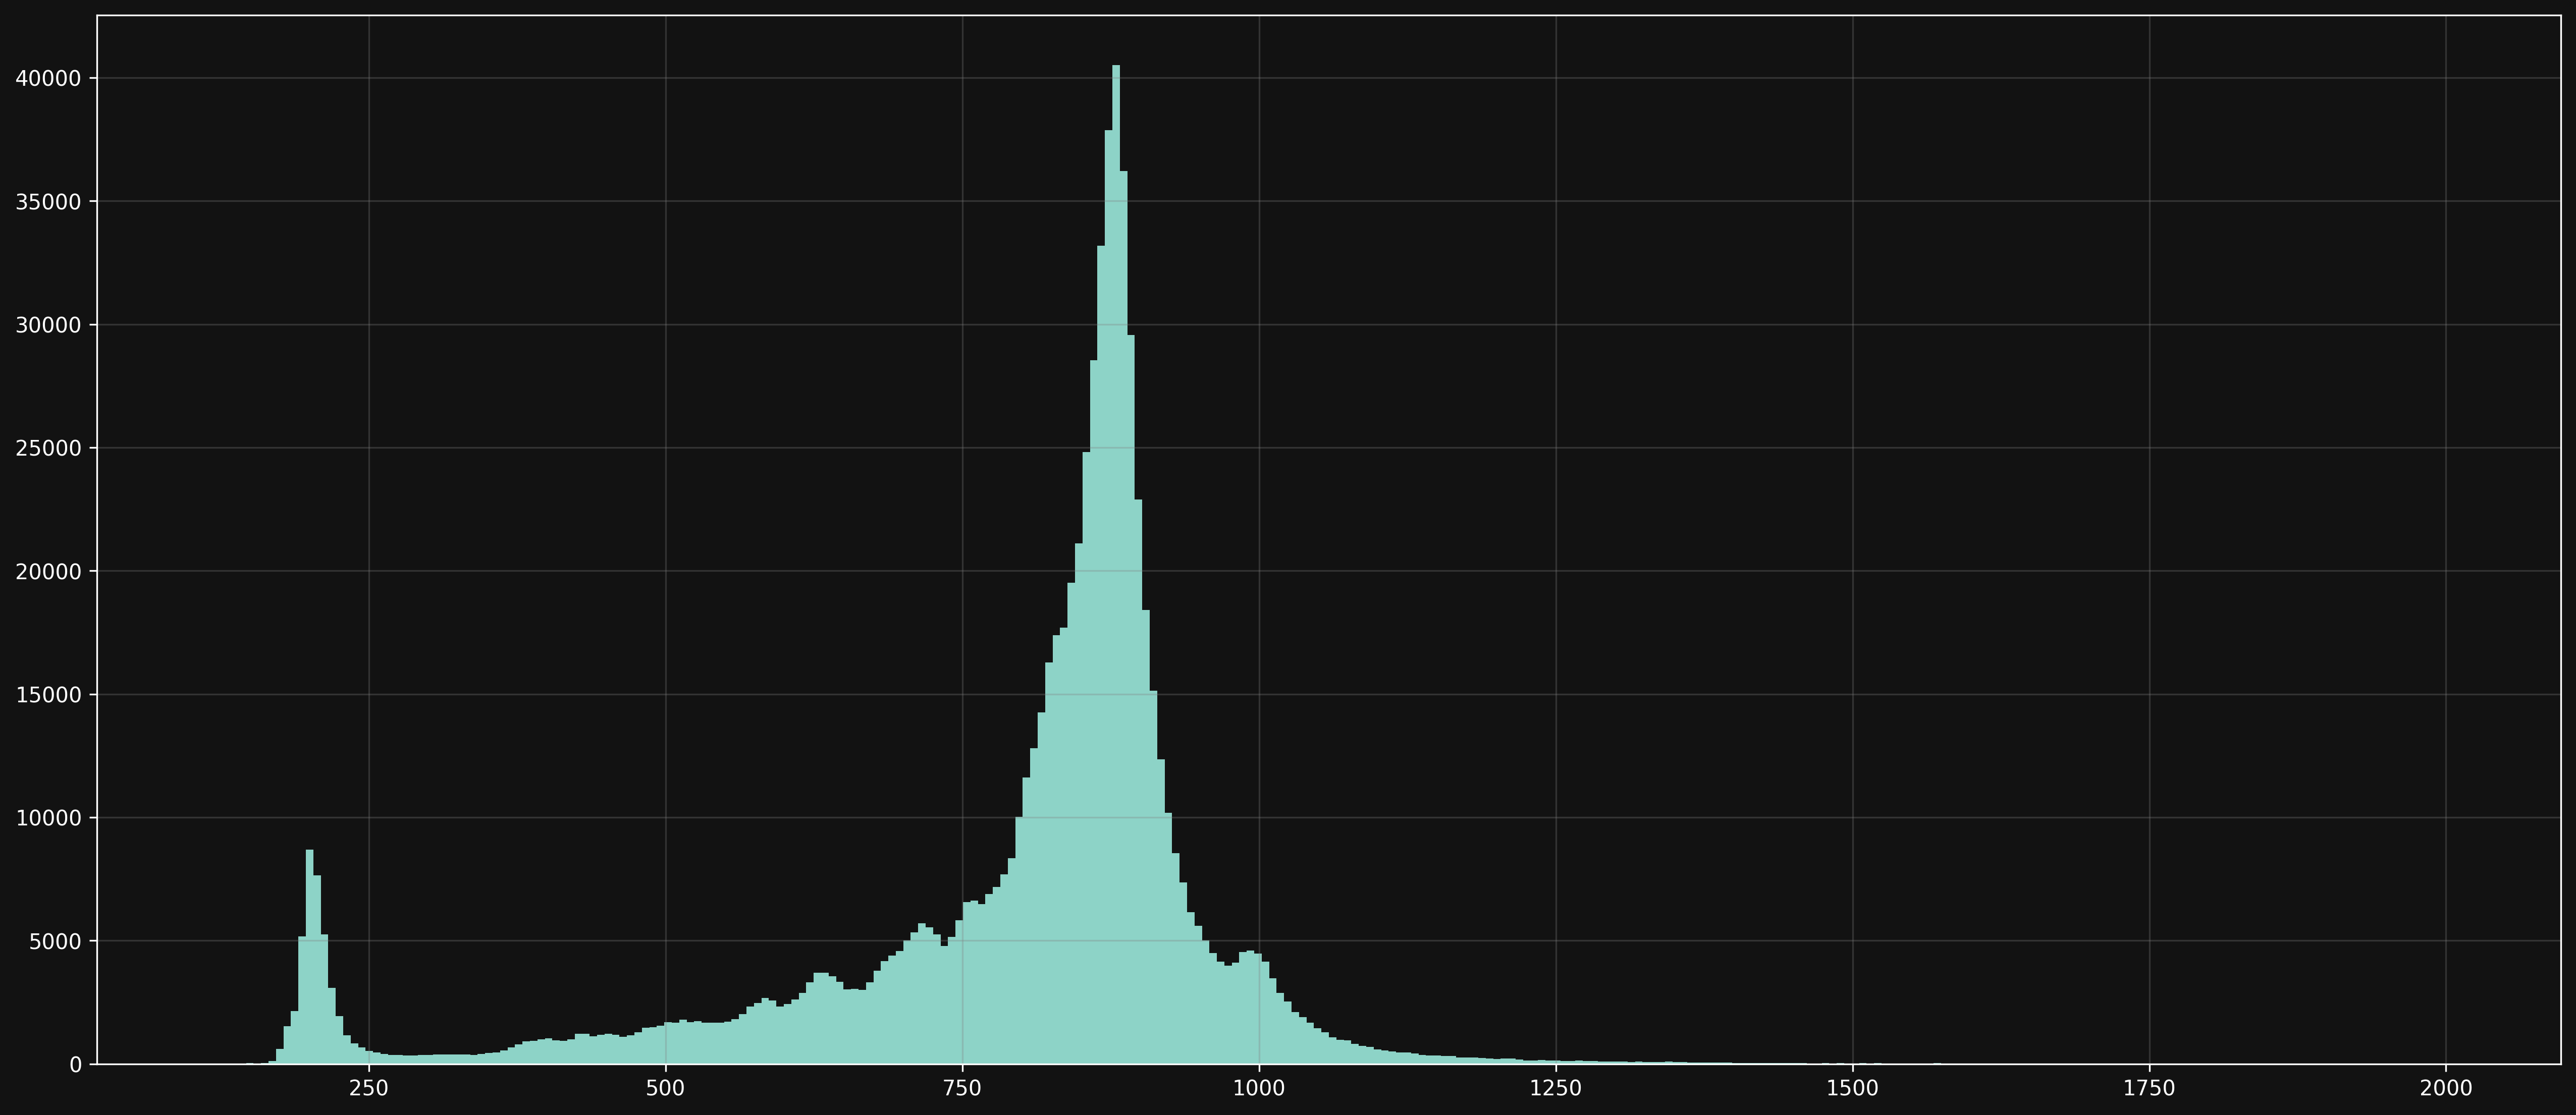

In [110]:
pd.Series(inverse_y(np.vstack(ps).T.max(axis=1)), index = test_data.index, name='Premium Amount').hist(bins=300)

In [ ]:
def mlse_with_inverse(preds, dtrain: np.ndarray):
    dtrain = inverse_y(dtrain)
    preds = inverse_y(preds)

    # preds = np.maximum(preds, epsilon)
    dtrain = np.log1p(dtrain)
    preds = np.log1p(preds)
    try:
        return 'RMLSE', np.sqrt(mean_squared_error(dtrain, preds)), False
    except:
        return 'RMLSE', 10, False

In [26]:
def lgbm_objective(trial: optuna.Trial):
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42) 
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 10),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 400, 600),
        'max_depth': trial.suggest_int('max_depth', 20, 40),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        # 'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 5),
        # "categorical_feature": categorical_columns.values,
        "seed": 42,
        'device_type': 'gpu',
        # "eval_metric": rmlse_with_inverse,
        "verbose": -1
    }

    models = []
    overall_score = 0 
    
    for i, (train_idx, val_idx) in enumerate(kf.split(X)):
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx] 
        
        model = LGBMRegressor(**params) 
        model.fit(
            X_train,
            y_train,
            eval_set=(X_val, y_val),
            eval_metric=rmlse_with_inverse,
        ) 
        
        models.append(model) 

        y_pred = model.predict(X_val)
        y_pred = inverse_y(y_pred)
        y_pred = np.maximum(0, y_pred)
        y_val = inverse_y(y_val)
        score = rmlse(y_val, y_pred)[1]
        
        overall_score += score 
        
        print(f'=== Fold {i + 1} RMSLE Score: {score:} ===') 
        
    avg_score = overall_score / kf.n_splits 
    print(f"Overall RMSLE: {avg_score}") 

    return avg_score 

In [27]:
study = optuna.create_study(direction='minimize')
study.optimize(lgbm_objective, n_trials=100, )

[I 2024-12-26 18:39:25,717] A new study created in memory with name: no-name-4622a3b8-761c-4754-b981-116b2ff17744


=== Fold 1 RMSLE Score: 1.0334373044678296 ===
=== Fold 2 RMSLE Score: 1.032322917350245 ===
=== Fold 3 RMSLE Score: 1.0339506781037344 ===
=== Fold 4 RMSLE Score: 1.0311663775956317 ===


[I 2024-12-26 18:41:33,034] Trial 0 finished with value: 1.0328446281388328 and parameters: {'num_leaves': 25, 'min_child_samples': 9, 'min_child_weight': 0.01742445783616352, 'n_estimators': 443, 'max_depth': 31, 'learning_rate': 0.010049713714955272, 'feature_fraction': 0.9838569485796165, 'bagging_fraction': 0.8706816115884023, 'lambda_l1': 0.8518384167007444, 'lambda_l2': 0.01589194514962719, 'reg_alpha': 0.013900066021231325, 'reg_lambda': 0.7506999786723523, 'subsample_freq': 2}. Best is trial 0 with value: 1.0328446281388328.


=== Fold 5 RMSLE Score: 1.0333458631767236 ===
Overall RMSLE: 1.0328446281388328


[W 2024-12-26 18:41:47,017] Trial 1 failed with parameters: {'num_leaves': 27, 'min_child_samples': 5, 'min_child_weight': 0.0012149948329592962, 'n_estimators': 568, 'max_depth': 35, 'learning_rate': 0.018762047356438882, 'feature_fraction': 0.7804745666844903, 'bagging_fraction': 0.630057432088643, 'lambda_l1': 0.5921015543315116, 'lambda_l2': 3.150467826184469, 'reg_alpha': 4.8306304997821465, 'reg_lambda': 0.013399130272965418, 'subsample_freq': 2} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\gus47\Desktop\workspace\kaggle\regression-with-an-insurance-dataset\.venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\gus47\AppData\Local\Temp\ipykernel_6764\3464246506.py", line 35, in lgbm_objective
    model.fit(
  File "c:\Users\gus47\Desktop\workspace\kaggle\regression-with-an-insurance-dataset\.venv\Lib\site-packages\li

KeyboardInterrupt: 

In [28]:
study.best_params

{'n_estimators': 904,
 'learning_rate': 0.22397849703318146,
 'max_depth': 6,
 'reg_lambda': 1.0772060124044087,
 'subsample': 0.7276099887947944,
 'subsample_freq': 1,
 'min_child_samples': 12}

In [15]:
# optuna parameter search near num_leaves=31, min_child_samples=7, min_child_weight=0.003, n_estimators=500, max_depth=30, learning_rate=0.1 and wide range search for other parameters
y_val_origin = inverse_y(y_val)
def objective(trial: optuna.Trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 10),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 400, 600),
        'max_depth': trial.suggest_int('max_depth', 20, 40),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        
    }

    scores = 0
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for i, (train_idx, val_idx) in enumerate(kf.split(X)):
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]

        y_train, y_val = y[train_idx], y[val_idx] 
        model = LGBMRegressor(
            gpu_id=0,
            n_jobs=-1,
            device_type='gpu',
            verbosity=-1,
            **params,
        )
        model.fit(
            X_train,
            y_train,
            eval_set=(X_val, y_val),
            eval_metric=rmlse_with_inverse,
        ) 

        y_pred = model.predict(X_val)
        scores[val_idx] = np.maximum(0, y_pred) 
        
        score = rmlse_with_inverse(y_val, y_pred)[1]
        
        overall_score += score 
        
        print(f'=== Fold {i + 1} RMSLE Score: {score:} ===') 
        
    avg_score = overall_score / kf.n_splits 
    print(f"Overall RMSLE: {avg_score}") 
    
    return avg_score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-12-26 18:20:30,871] A new study created in memory with name: no-name-74029ec1-87db-4e89-8da4-e479ce75add5
[W 2024-12-26 18:22:06,006] Trial 0 failed with parameters: {'num_leaves': 27, 'min_child_samples': 10, 'min_child_weight': 0.006456430338839898, 'n_estimators': 595, 'max_depth': 39, 'learning_rate': 0.08506425836411159, 'feature_fraction': 0.8969224427714775, 'bagging_fraction': 0.6356935506253792, 'lambda_l1': 0.022994319446658085, 'lambda_l2': 0.005604092842773005, 'reg_alpha': 0.0072958046308591856, 'reg_lambda': 3.33350882775879, 'boosting_type': 'dart'} because of the following error: TypeError("'int' object does not support item assignment").
Traceback (most recent call last):
  File "c:\Users\gus47\Desktop\workspace\kaggle\regression-with-an-insurance-dataset\.venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\gus47\AppData\Local\Temp\ipykernel_6764\39869517

TypeError: 'int' object does not support item assignment

In [46]:
study.best_params, study.best_value

({'num_leaves': 40,
  'min_child_samples': 10,
  'min_child_weight': 0.06465924287223622,
  'n_estimators': 459,
  'max_depth': 30,
  'learning_rate': 0.046995524079346984,
  'feature_fraction': 0.9677961468326596,
  'bagging_fraction': 0.6627290192138932,
  'lambda_l1': 8.692580281983838,
  'lambda_l2': 3.4256066884728638,
  'reg_alpha': 0.08455745202708774,
  'reg_lambda': 0.007744807329888691,
  'boosting_type': 'gbdt'},
 1.0462689704206725)

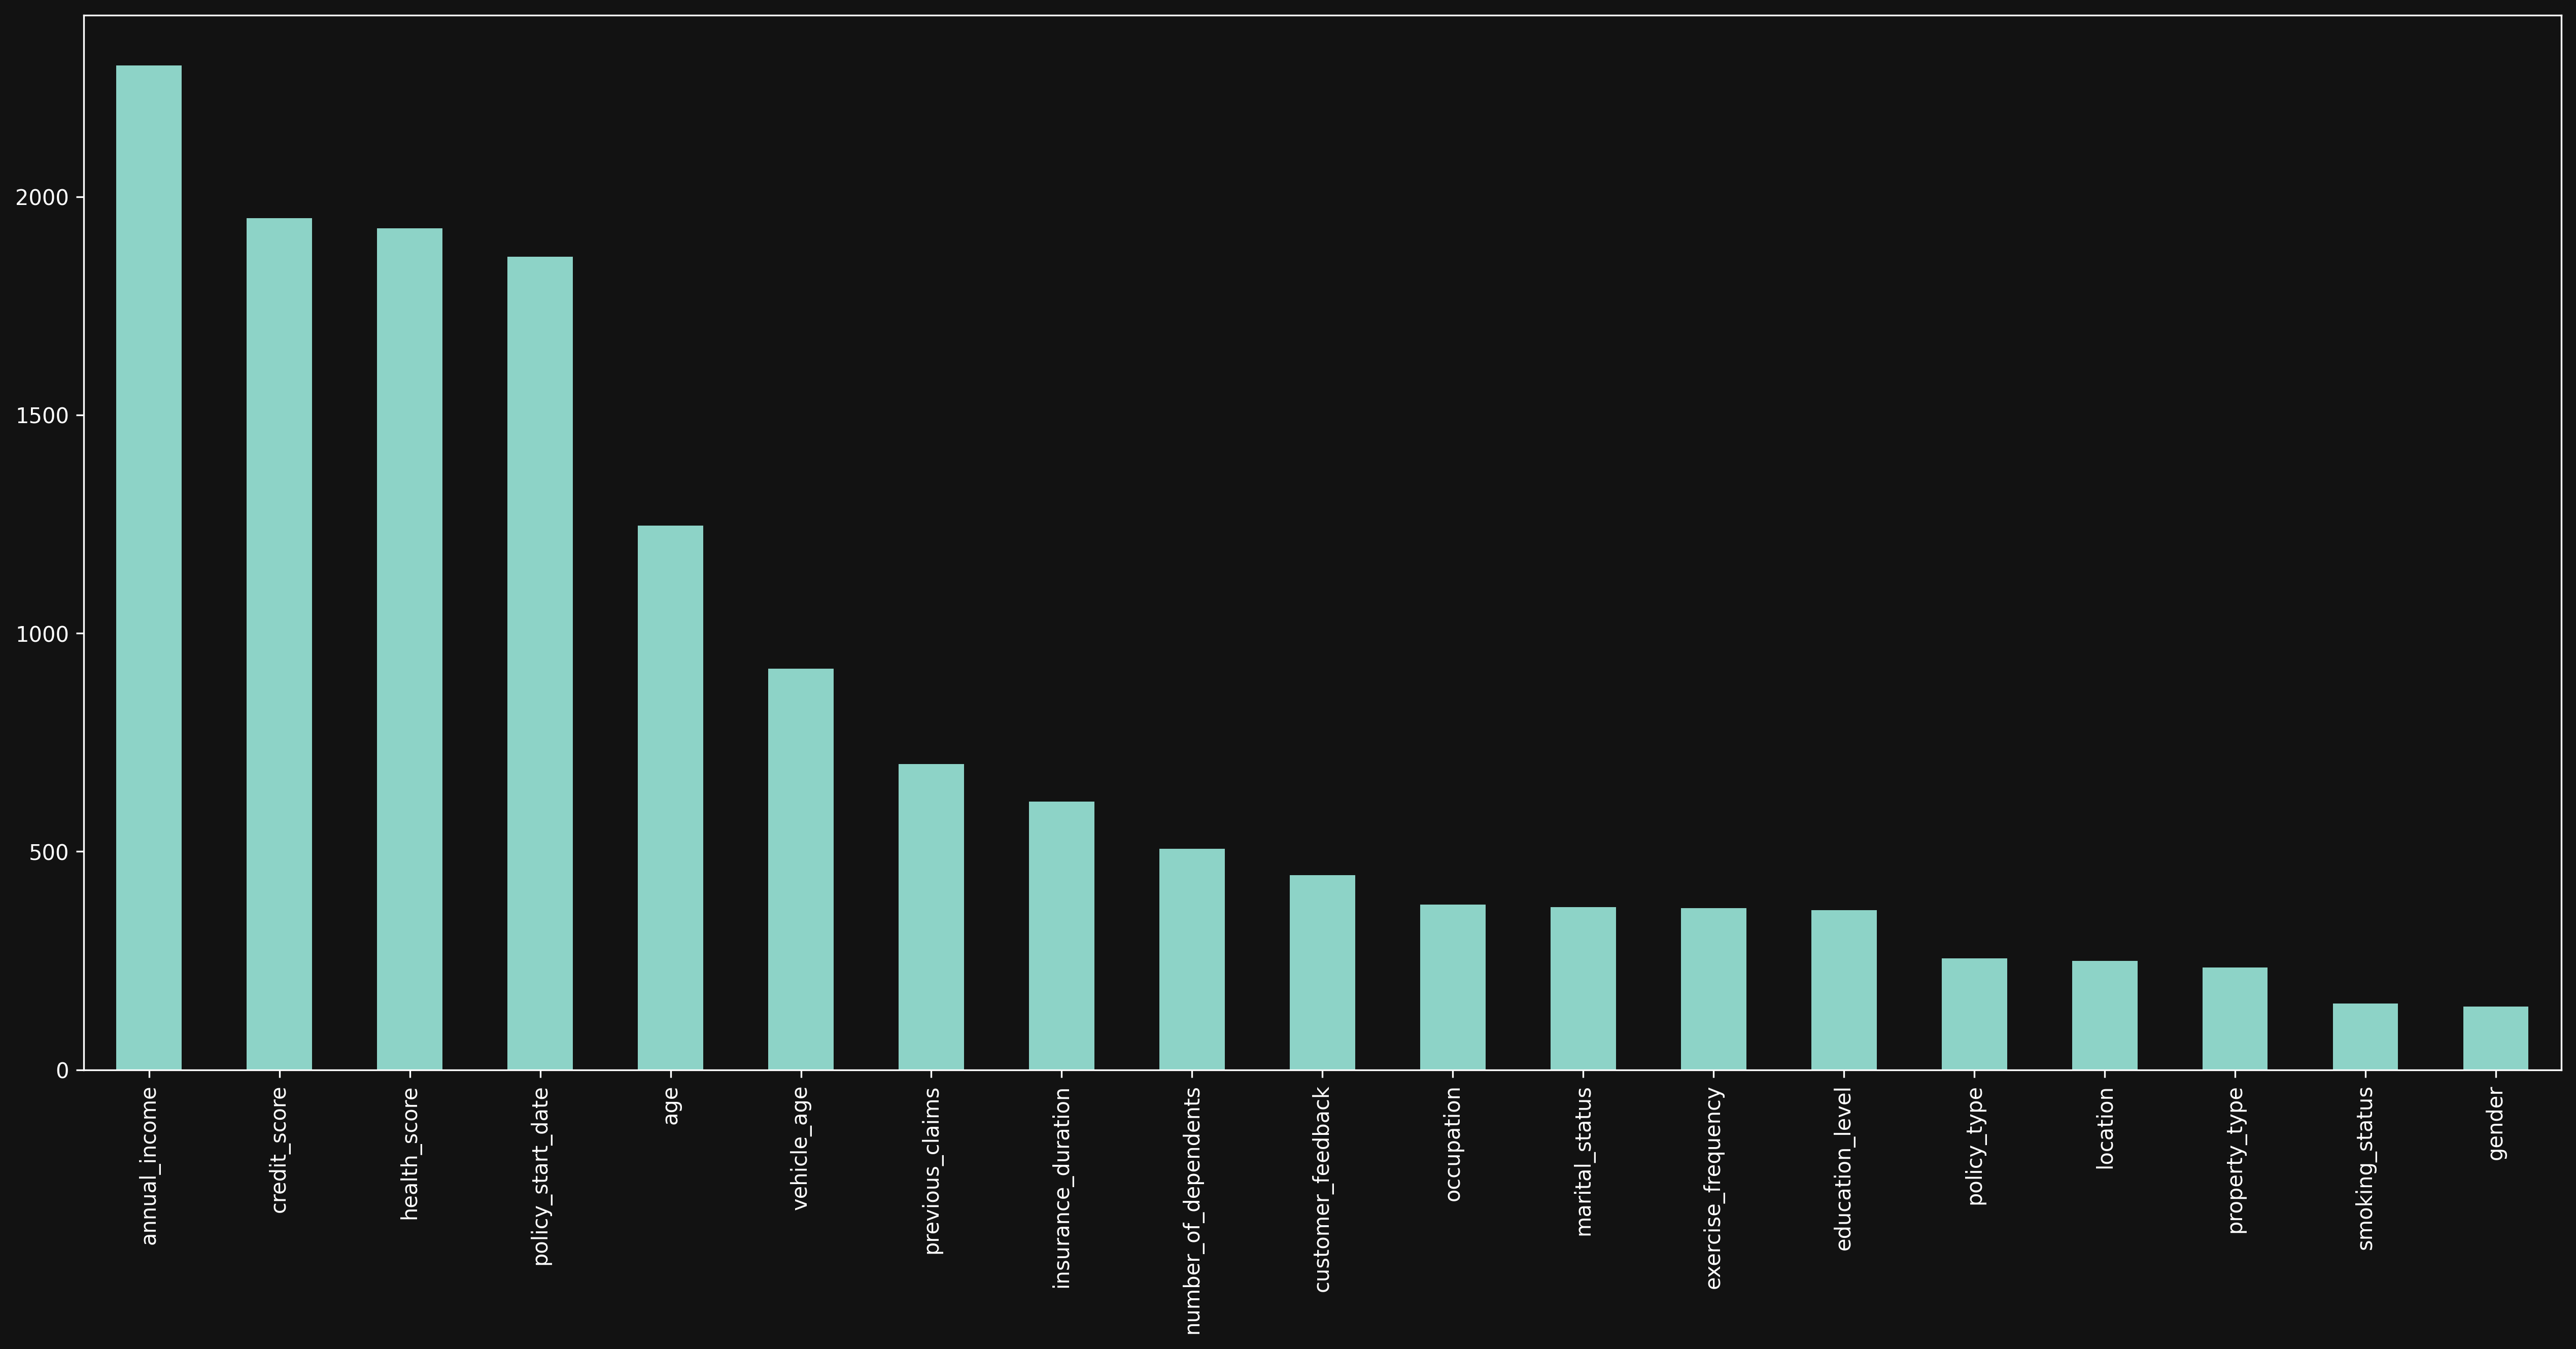

In [90]:
pd.Series(lgbm.feature_importances_, index=X.columns).sort_values(ascending=False).plot(kind='bar')
importance = pd.Series(lgbm.feature_importances_, index=X.columns).sort_values(ascending=False)

In [124]:
from sklearn.ensemble import StackingRegressor
# stack catboost, xgboost, lightgbm
cbr = cat.CatBoostRegressor(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.1,
    random_state=42,
    verbose=1,
    # task_type='GPU'
)


xgbr = XGBRegressor(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    objective='reg:squarederror',
    # eval_metric='r2',
    gpu_id=0,
    # num_parallel_tree=1,
    # callbacks=[early_stop]
)

lgbr = LGBMRegressor(
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=500,
    max_depth=30,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    verbosity=1,
)
print('fitting... catboost')
cbr.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50)
print('fitting... xgboost')
xgbr.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50)
print('fitting... lightgbm')
lgbr.fit(X_train, y_train, eval_set=[(X_val, y_val)])

estimators = [
    ('cbr', cbr),
    ('xgbr', xgbr),
    ('lgbm', lgbm)
]
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1, max_depth=20, verbose=50)
)
print('fitting... stack')
stack.fit(X_train, y_train)

0:	learn: 0.9917899	test: 0.9928262	best: 0.9928262 (0)	total: 390ms	remaining: 3m 14s
50:	learn: 0.9293068	test: 0.9580273	best: 0.9576874 (31)	total: 9.89s	remaining: 1m 27s
100:	learn: 0.8917020	test: 0.9599244	best: 0.9576874 (31)	total: 19.5s	remaining: 1m 17s
150:	learn: 0.8610101	test: 0.9615506	best: 0.9576874 (31)	total: 29.4s	remaining: 1m 7s
200:	learn: 0.8400563	test: 0.9627412	best: 0.9576874 (31)	total: 42.3s	remaining: 1m 2s
250:	learn: 0.8177627	test: 0.9639827	best: 0.9576874 (31)	total: 53s	remaining: 52.5s
300:	learn: 0.7942851	test: 0.9656090	best: 0.9576874 (31)	total: 1m 3s	remaining: 42.1s
350:	learn: 0.7710823	test: 0.9672136	best: 0.9576874 (31)	total: 1m 13s	remaining: 31.3s
400:	learn: 0.7500571	test: 0.9687988	best: 0.9576874 (31)	total: 1m 24s	remaining: 20.9s
450:	learn: 0.7304150	test: 0.9701036	best: 0.9576874 (31)	total: 1m 34s	remaining: 10.3s
499:	learn: 0.7115925	test: 0.9714944	best: 0.9576874 (31)	total: 1m 44s	remaining: 0us

bestTest = 0.95768744

StackingRegressor(estimators=[('cbr',
                               <catboost.core.CatBoostRegressor object at 0x17bf6e090>),
                              ('xgbr',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=0, grow_po...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=-1,
                                            num_parallel_tree=None, ...)),
                              ('lgbm',
                               LGBMRegressor(max_depth=30, min_child_samples=7,
                                             min_child_weight=0.003,
                                             n_estimators=500, n_jobs=-1,
                                             random_state=42, verbosity=1))],
                  final_estimator=RandomForestRegressor(max_depth=20,
                                                        n_estimators=500,
                                                        n_jobs=-1,
                                                        random_state=42,
                                                        verbose=50))

In [125]:
evaluate_model(stack, X_val, y_val)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.2s
[Para

(0.08649293657367696, 0.9144881065351448, 1.0479243516327004)

In [ ]:
test = data[data[target_column].isna()].drop(columns=[target_column, 'policy_type', 'location', 'property_type', 'smoking_status', 'gender'])
stack_pred=stack.predict(test)

In [131]:
inverse_y(stack_pred)

array([787.61949332, 831.48962063, 803.0568907 , ..., 826.88374633,
       757.40566722, 792.6202044 ])

In [362]:
# early_stopping_rounds
early_stop = xgb.callback.EarlyStopping(
    rounds=10, data_name='validation_0', save_best=True,# metric_name='rmse',
)
xgbr = XGBRegressor(
    n_estimators=500,
    disable_default_eval_metric=True,
    max_depth=15,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    # objective='reg:squaredlogerror',
    # objective=squared_log,
    objective=rmlse_objective,
    eval_metric=rmlse_evaluation,
    gpu_id=0,
    # num_parallel_tree=1,
    callbacks=[early_stop]
)
xgbr.fit(X_train, inverse_y(y_train), eval_set=[(X_train, inverse_y(y_train)), (X_val, inverse_y(y_val))], verbose=10)

[0]	validation_0-rmlse_evaluation:0.00613	validation_1-rmlse_evaluation:0.01225
[10]	validation_0-rmlse_evaluation:0.00547	validation_1-rmlse_evaluation:0.01093
[20]	validation_0-rmlse_evaluation:0.00467	validation_1-rmlse_evaluation:0.00935
[30]	validation_0-rmlse_evaluation:0.00391	validation_1-rmlse_evaluation:0.00782
[40]	validation_0-rmlse_evaluation:0.00319	validation_1-rmlse_evaluation:0.00639
[50]	validation_0-rmlse_evaluation:0.00254	validation_1-rmlse_evaluation:0.00508
[60]	validation_0-rmlse_evaluation:0.00198	validation_1-rmlse_evaluation:0.00396
[70]	validation_0-rmlse_evaluation:0.00155	validation_1-rmlse_evaluation:0.00310
[80]	validation_0-rmlse_evaluation:0.00129	validation_1-rmlse_evaluation:0.00258
[90]	validation_0-rmlse_evaluation:0.00117	validation_1-rmlse_evaluation:0.00234
[100]	validation_0-rmlse_evaluation:0.00113	validation_1-rmlse_evaluation:0.00226
[110]	validation_0-rmlse_evaluation:0.00111	validation_1-rmlse_evaluation:0.00223
[120]	validation_0-rmlse_ev

XGBRegressor(base_score=None, booster=None,
             callbacks=[<xgboost.callback.EarlyStopping object at 0x3001b61e0>],
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None,
             disable_default_eval_metric=True, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function rmlse_evaluation at 0x30019c220>,
             feature_types=None, gamma=None, gpu_id=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, ...)

In [364]:
evaluate_model_no_inverse(xgbr, X_val, inverse_y(y_val))

(-0.2166216956468372, 909163.8569230675, 1.0846654976421648)

In [323]:
evaluate_model_no_inverse(xgbr, X_val, inverse_y(y_val))

(-0.21583451785926044, 908575.6103086942, 1.0847206771631082)

In [384]:
# catboost with rmlse
cbr = cat.CatBoostRegressor(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.1,
    random_state=42,
    verbose=10,
    eval_metric=RMLSEMetricInv()
)
cbr.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=30)
evaluate_model(cbr, X_val, y_val)

0:	learn: 0.0011092	test: 0.0022208	best: 0.0022208 (0)	total: 331ms	remaining: 2m 45s
10:	learn: 0.0010717	test: 0.0021529	best: 0.0021529 (10)	total: 2.26s	remaining: 1m 40s
20:	learn: 0.0010618	test: 0.0021437	best: 0.0021437 (20)	total: 4.54s	remaining: 1m 43s
30:	learn: 0.0010542	test: 0.0021423	best: 0.0021423 (30)	total: 6.54s	remaining: 1m 38s
40:	learn: 0.0010465	test: 0.0021428	best: 0.0021422 (31)	total: 8.6s	remaining: 1m 36s
50:	learn: 0.0010394	test: 0.0021430	best: 0.0021422 (31)	total: 10.9s	remaining: 1m 35s
60:	learn: 0.0010313	test: 0.0021436	best: 0.0021422 (31)	total: 13s	remaining: 1m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.002142195343
bestIteration = 31

Shrink model to first 32 iterations.


(0.08381867950551047, 0.9171652355695751, 1.049457109954584)

In [29]:
lgbr = LGBMRegressor(
    num_leaves=31,
    min_child_samples=20,
    min_child_weight=0.001,
    
    n_estimators=500,
    max_depth=20,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    # verbosity=1,
)

lgbr.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=rmlse_with_inverse)
evaluate_model(lgbr, X_val, y_val)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1134
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 14
[LightGBM] [Info] Start training from score -0.000037


(0.0886444581018001, 0.9123342744224042, 1.0466895714082922)

In [ ]:
evaluate_model(lgbr, X_val, y_val)

(0.0886444581018001, 0.9123342744224042, 1.0466895714082922)

In [ ]:
# SVM
from sklearn.svm import SVR
svr = SVR(
    C=1,
    epsilon=2.25,
)
svr.fit(X_train, y_train)

In [218]:
import pickle
svr = pd.read_pickle('svr.pkl')

In [75]:
# save svr model because it takes too long to train
import pickle
with open('svr.pkl', 'wb') as f:
    pickle.dump(svr, f)

In [220]:
evaluate_model(svr, X_val[:, 1:], y_val)

(-0.41186115869286777, 1.4133773994706387, 1.3027766711381177)

# Submission

In [50]:
test = data[data[target_column].isna()].drop(columns=[target_column])

In [52]:
def make_ans(model):
    ans=inverse_y(model.predict(test.values))
    return pd.Series(ans, index = test.index).rename('Premium Amount')

In [54]:
ans = make_ans(lgbm)
ans.to_csv('submission.csv', header=True)